In [1]:
!pip install -q imbalanced-learn xgboost lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [47]:
df_test = pd.read_csv('/content/trainset_creditcard.csv')

# EDA

In [48]:
# Display the first few rows of the dataset
df_test.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [49]:
# Check for missing values
missing_values = df_test.isnull().sum()
print("Missing values in the dataset:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values found")

# Get basic information about the dataset
print("\nDataset info:")
df_test.info()

Missing values in the dataset:
age    126
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-nu

In [50]:
df_test.duplicated().sum()

np.int64(0)

In [51]:
df_test.isnull().sum()

,0
Customer_ID,0
marriage,0
sex,0
education,0
LIMIT_BAL,0
age,126
pay_0,0
pay_2,0
pay_3,0
pay_4,0


Drop null value rows(very small compared to data)

In [52]:
df_test = df_test.dropna(subset=['age'])


In [53]:
# Check the statistical summary of the dataset
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_ID,25121.0,17639.804546,7283.872392,5017.00,11334.00,17637.00,23947.00,30263.00
marriage,25121.0,1.551769,0.522538,0.00,1.00,2.00,2.00,3.00
sex,25121.0,0.604713,0.488922,0.00,0.00,1.00,1.00,1.00
education,25121.0,1.851996,0.797132,0.00,1.00,2.00,2.00,6.00
LIMIT_BAL,25121.0,168358.823295,129866.750911,10000.00,50000.00,140000.00,240000.00,1000000.00
age,25121.0,35.438199,9.174998,21.00,28.00,34.00,41.00,79.00
pay_0,25121.0,-0.043111,1.099224,-2.00,-1.00,0.00,0.00,8.00
pay_2,25121.0,-0.159747,1.174062,-2.00,-1.00,0.00,0.00,8.00
pay_3,25121.0,-0.190558,1.172957,-2.00,-1.00,0.00,0.00,8.00
pay_4,25121.0,-0.240994,1.147502,-2.00,-1.00,0.00,0.00,7.00


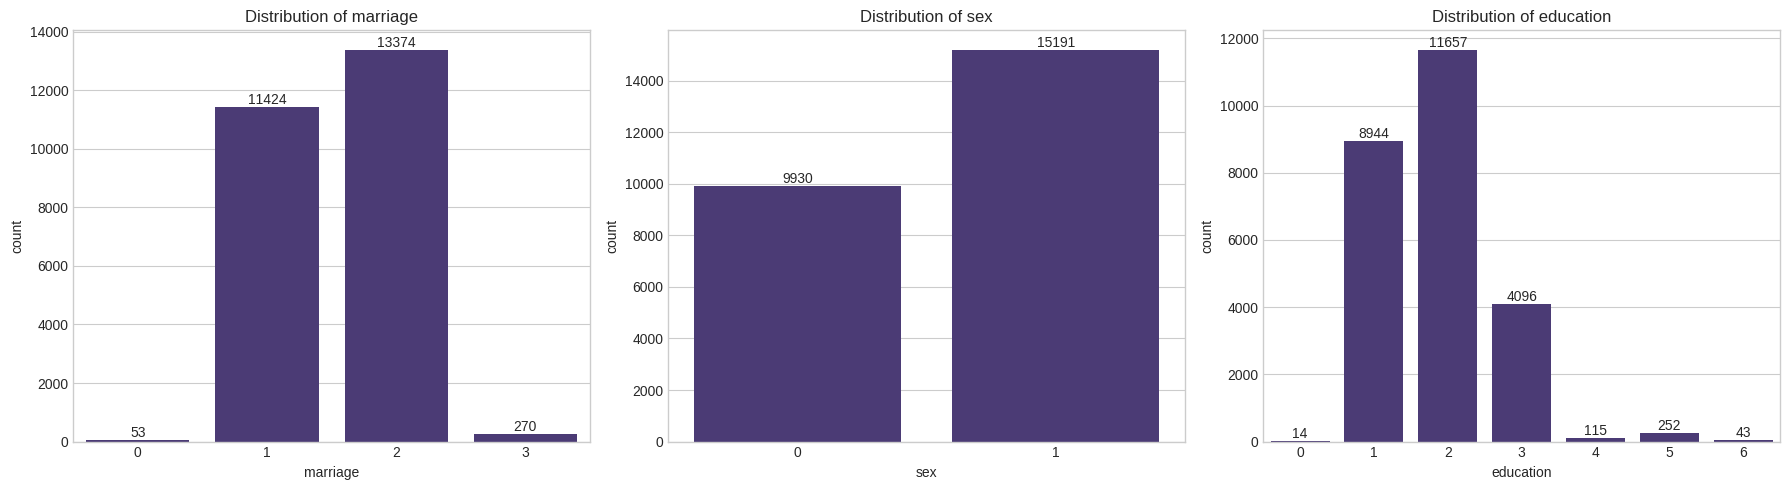

Marriage categories (based on documentation):
1: Married
2: Single
3: Others

Sex categories:
0: Female
1: Male

Education categories:
1: Graduate school
2: University
3: High school
4: Others
5-6: Unknown


In [54]:
# Let's examine the categorical variables and their distributions
categorical_cols = ['marriage', 'sex', 'education']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df_test, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

# More context on categorical variables:
print("Marriage categories (based on documentation):")
print("1: Married")
print("2: Single")
print("3: Others")
print("\nSex categories:")
print("0: Female")
print("1: Male")
print("\nEducation categories:")
print("1: Graduate school")
print("2: University")
print("3: High school")
print("4: Others")
print("5-6: Unknown")

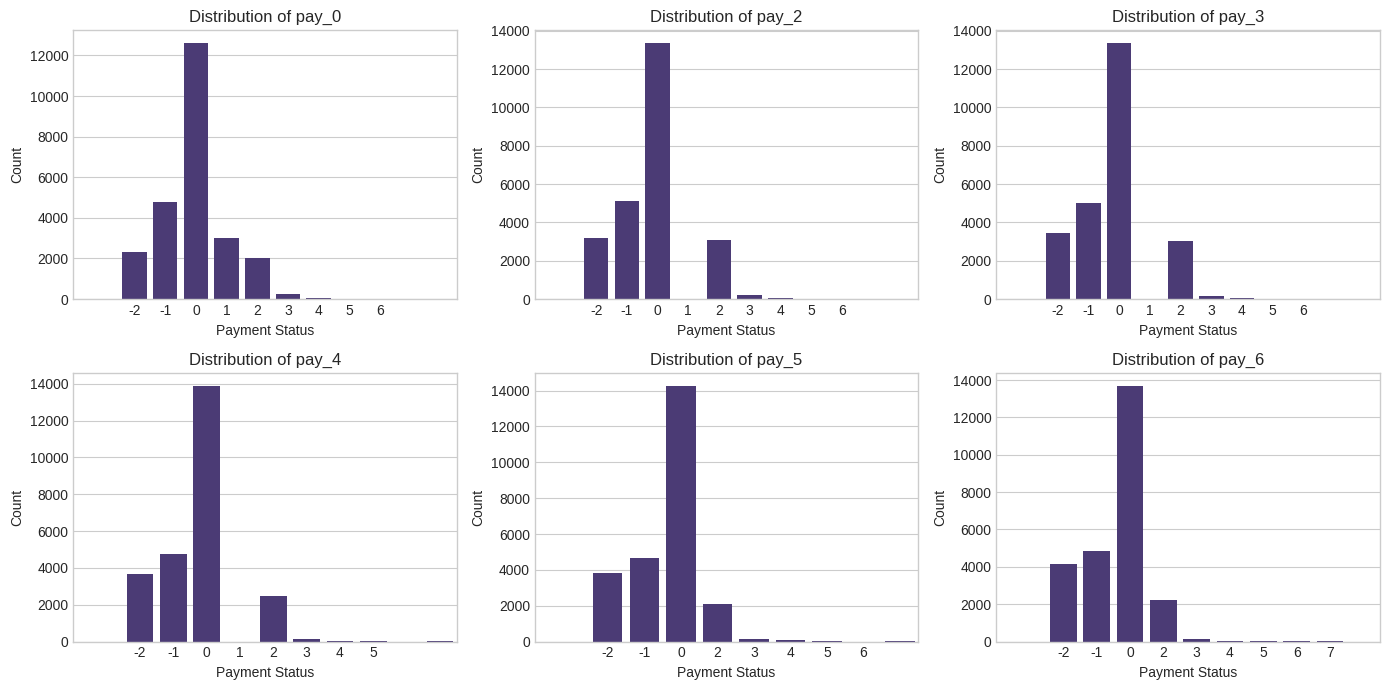

Payment status values interpretation:
-2: No consumption
-1: Paid in full
0: Revolving credit (paid minimum payment)
1+: Payment delay for n months (e.g., 2 = delayed by 2 months)


In [55]:
# Let's look at the distribution of payment status indicators
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

plt.figure(figsize=(14, 7))
for i, col in enumerate(pay_cols):
    plt.subplot(2, 3, i+1)
    # Count the occurrences of each payment status
    counts = df_test[col].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Payment Status')
    plt.ylabel('Count')
    # Only show whole numbers on x-axis
    plt.xticks(np.arange(min(counts.index), max(counts.index)+1, 1))

plt.tight_layout()
plt.show()

# Explanation of payment status categories
print("Payment status values interpretation:")
print("-2: No consumption")
print("-1: Paid in full")
print("0: Revolving credit (paid minimum payment)")
print("1+: Payment delay for n months (e.g., 2 = delayed by 2 months)")

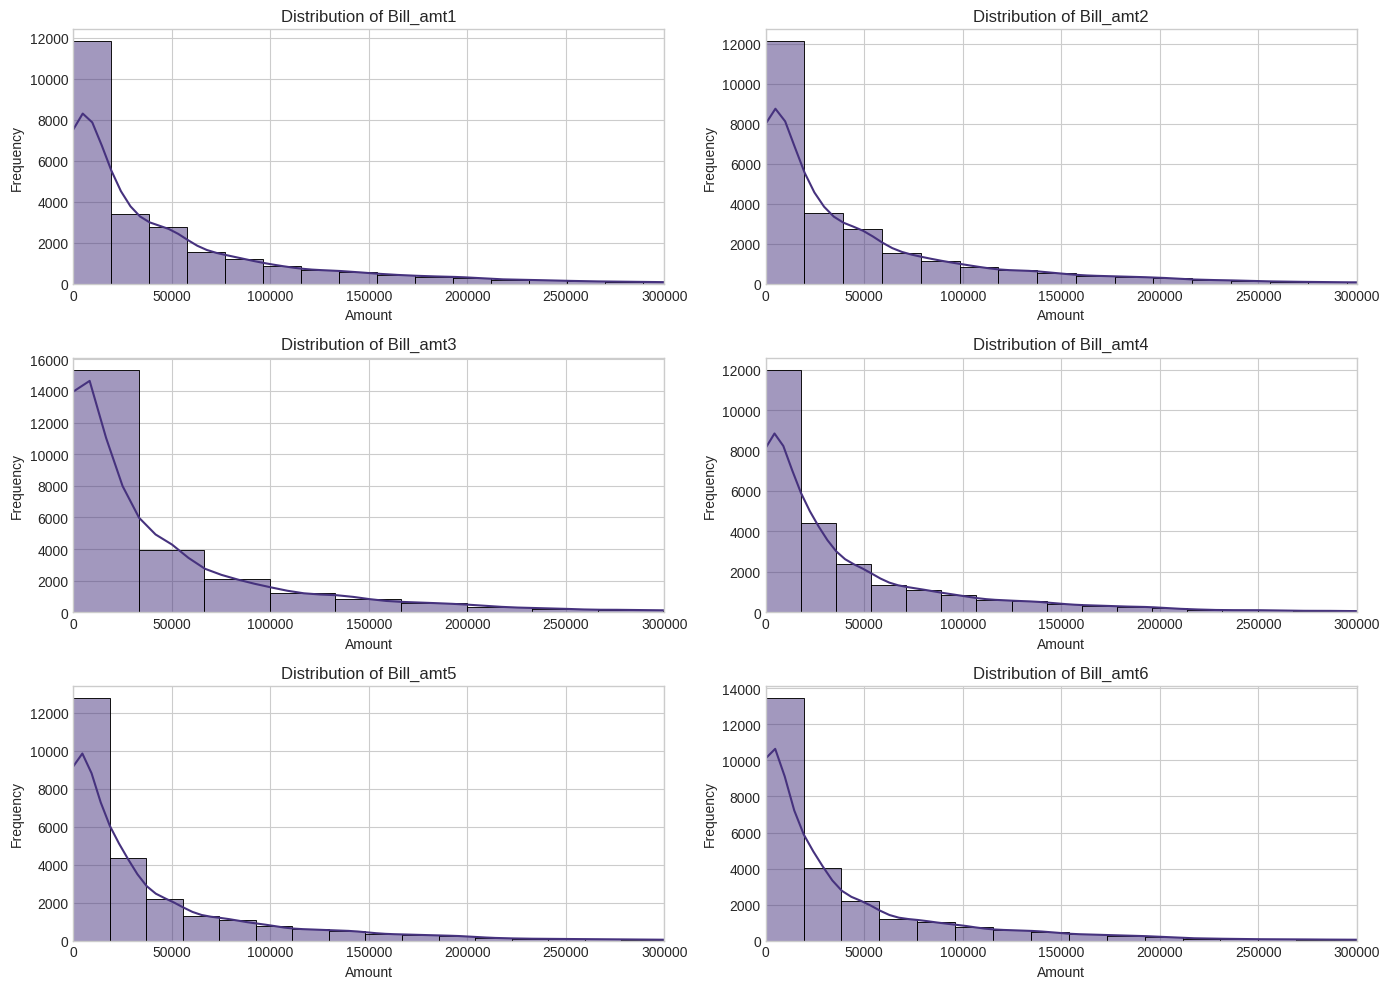

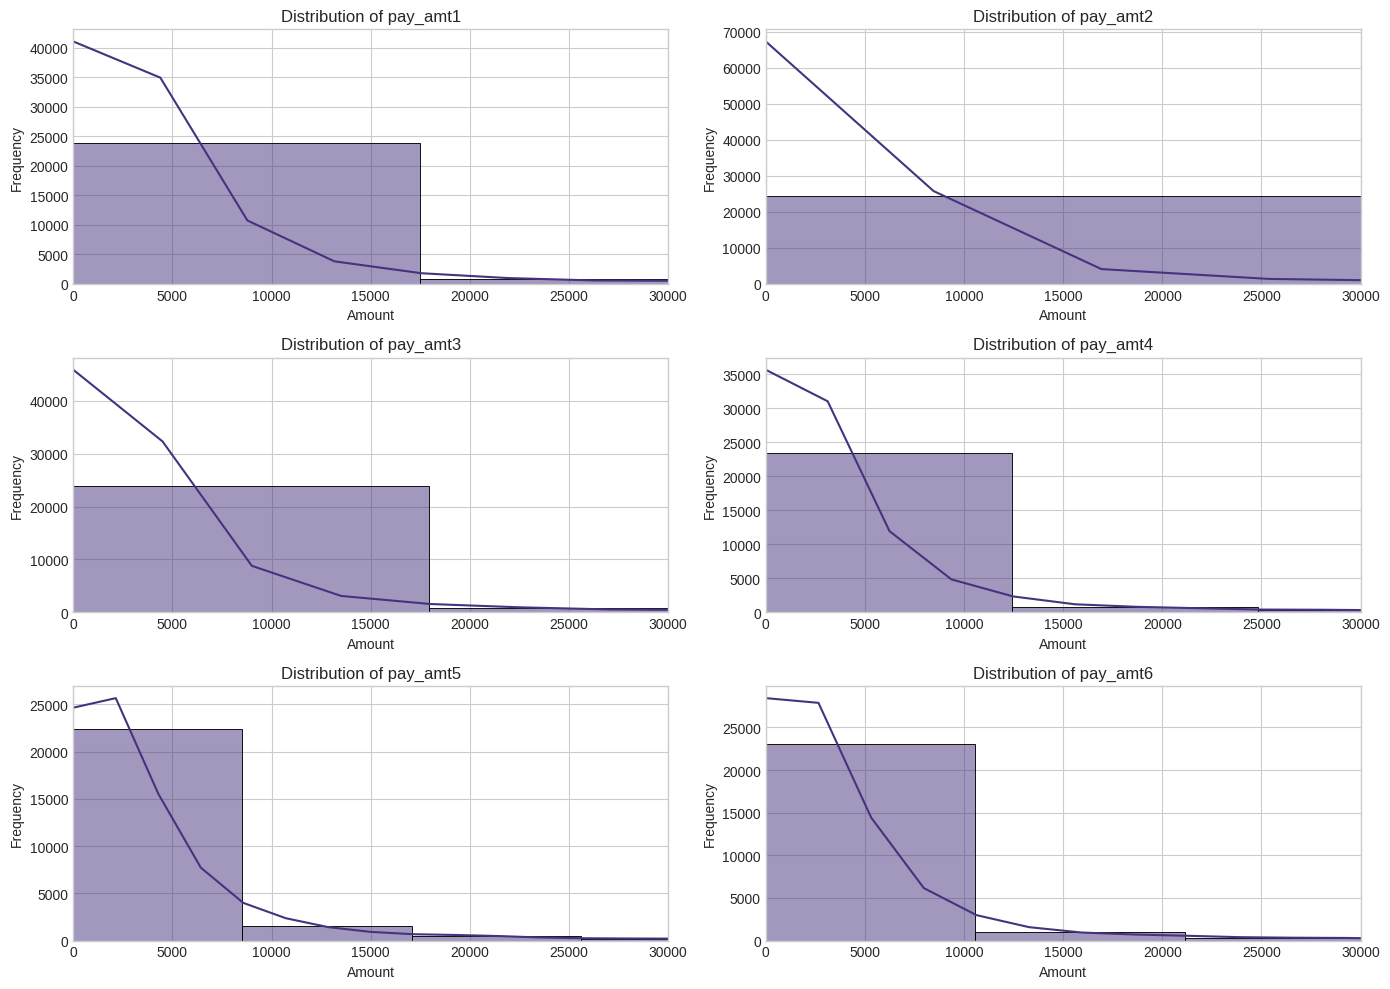

In [56]:
# Let's check the distribution of bill amounts and payment amounts
bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
pay_amt_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

# Creating histograms for bill amounts
plt.figure(figsize=(14, 10))
for i, col in enumerate(bill_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_test[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    # Set x-axis limit to cut off outliers for better visualization
    plt.xlim(0, 300000)
plt.tight_layout()
plt.show()

# Creating histograms for payment amounts
plt.figure(figsize=(14, 10))
for i, col in enumerate(pay_amt_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_test[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    # Set x-axis limit to cut off outliers for better visualization
    plt.xlim(0, 30000)
plt.tight_layout()
plt.show()

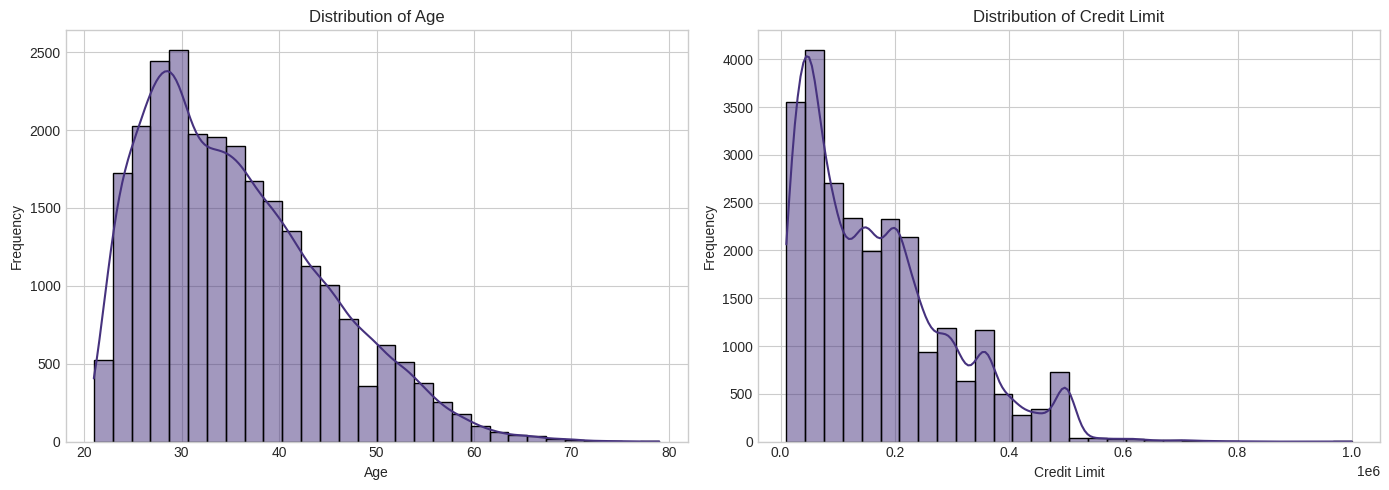

Age statistics:
count    25121.000000
mean        35.438199
std          9.174998
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: age, dtype: float64

Credit limit statistics:
count      25121.000000
mean      168358.823295
std       129866.750911
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64


In [57]:
# Let's visualize the age and credit limit distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_test['age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_test['LIMIT_BAL'], kde=True, bins=30)
plt.title('Distribution of Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Age and credit limit statistics
print("Age statistics:")
print(df_test['age'].describe())
print("\nCredit limit statistics:")
print(df_test['LIMIT_BAL'].describe())

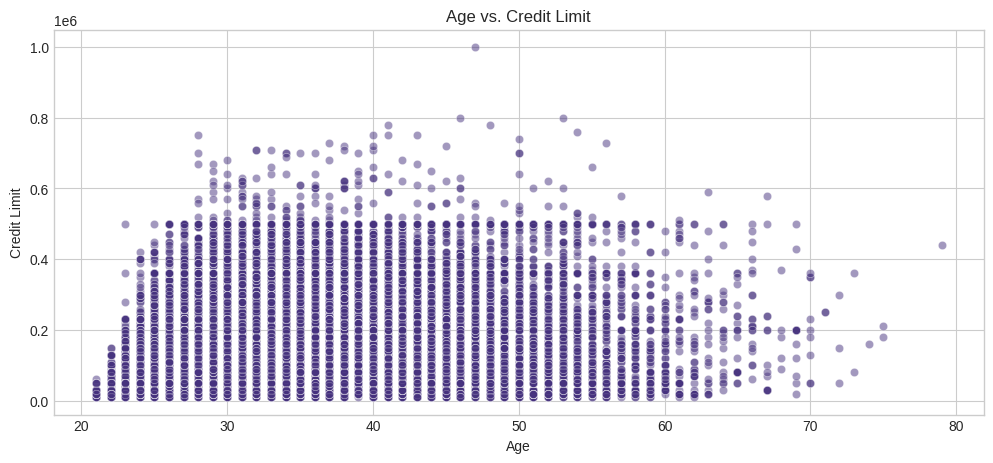

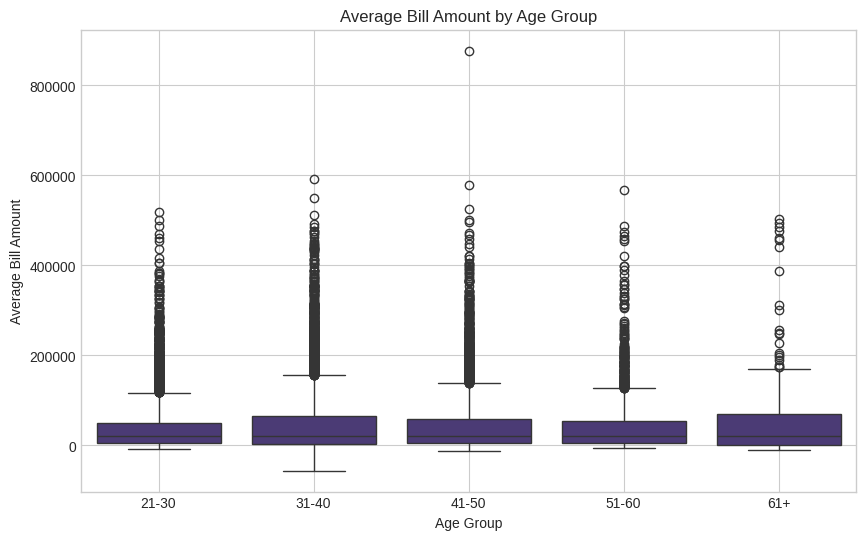

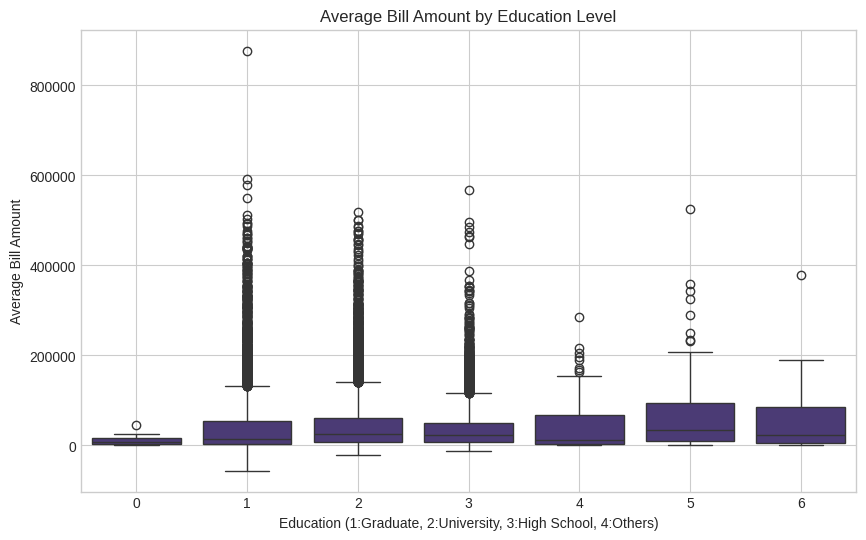

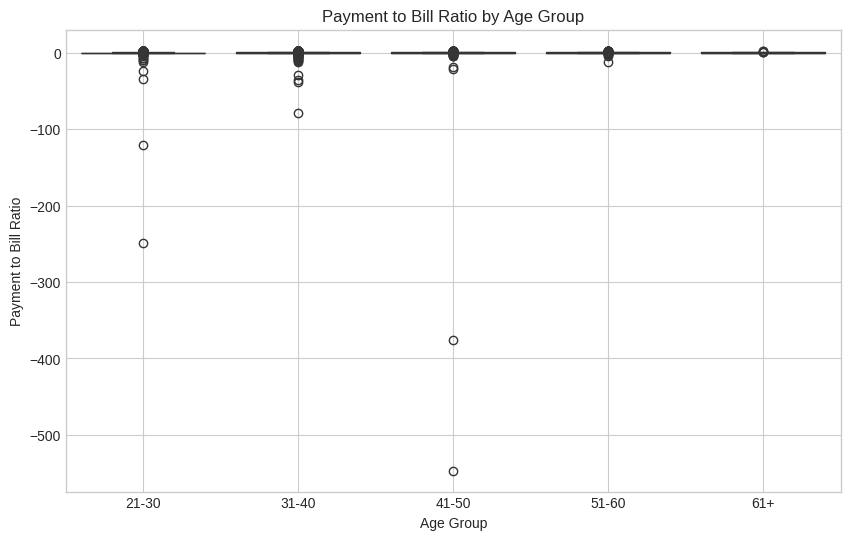

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Age vs. Credit Limit
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_test, x='age', y='LIMIT_BAL', alpha=0.5)
plt.title('Age vs. Credit Limit')
plt.xlabel('Age')
plt.ylabel('Credit Limit')
plt.grid(True)
plt.show()

# 2. Average Bill Amount by Age Group
df_plot = df_test.copy()
df_plot['age_group'] = pd.cut(df_plot['age'], bins=[20, 30, 40, 50, 60, 80],
                              labels=['21-30', '31-40', '41-50', '51-60', '61+'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='age_group', y='AVG_Bill_amt')
plt.title('Average Bill Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Bill Amount')
plt.grid(True)
plt.show()

# 3. Average Bill Amount by Education Level
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_test, x='education', y='AVG_Bill_amt')
plt.title('Average Bill Amount by Education Level')
plt.xlabel('Education (1:Graduate, 2:University, 3:High School, 4:Others)')
plt.ylabel('Average Bill Amount')
plt.grid(True)
plt.show()

# 4. PAY_TO_BILL_ratio by Age Group (without modifying df_test)
df_plot = df_test.copy()
df_plot['age_group'] = pd.cut(df_plot['age'], bins=[20, 30, 40, 50, 60, 80],
                              labels=['21-30', '31-40', '41-50', '51-60', '61+'])
df_plot_filtered = df_plot[df_plot['PAY_TO_BILL_ratio'] <= 3]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot_filtered, x='age_group', y='PAY_TO_BILL_ratio')
plt.title('Payment to Bill Ratio by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Payment to Bill Ratio')
plt.grid(True)
plt.show()


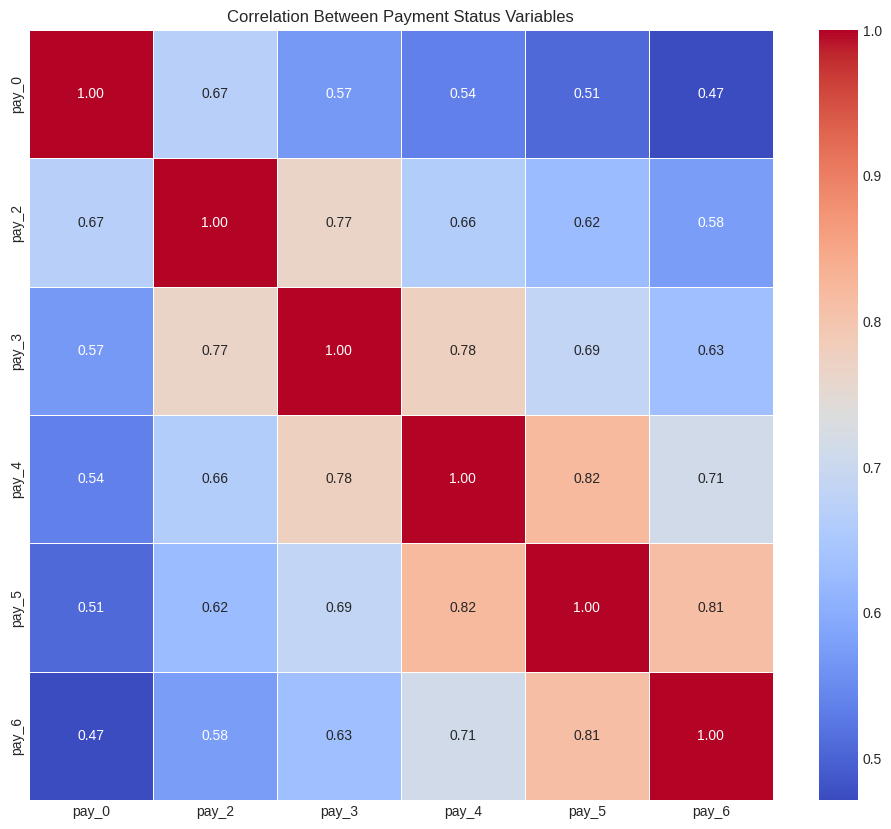

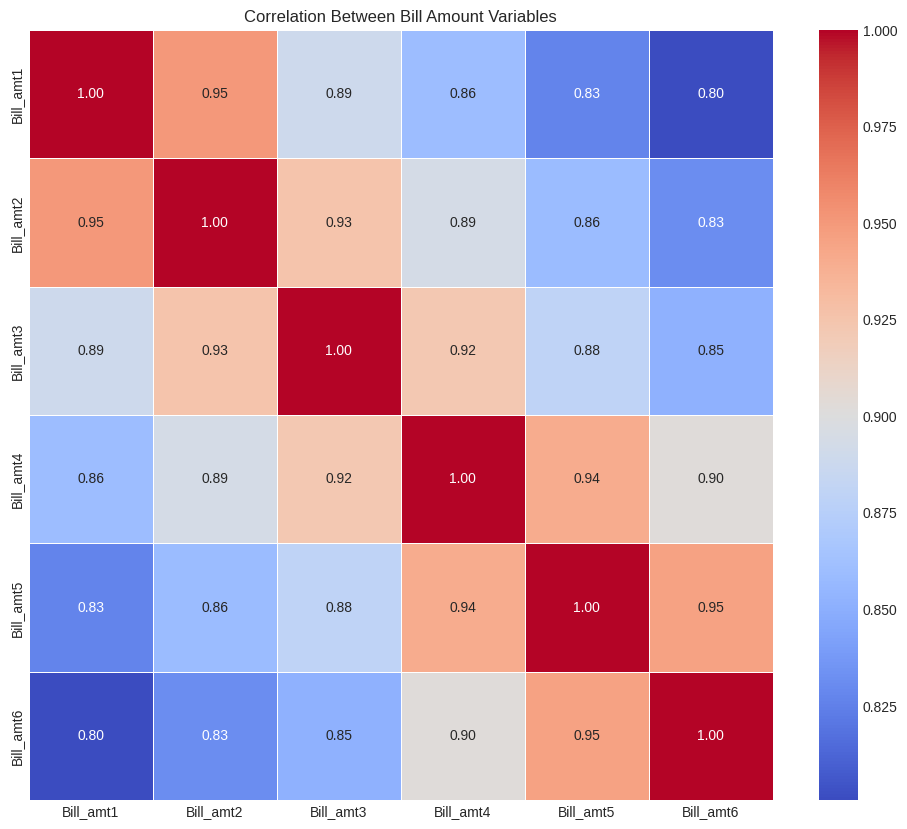

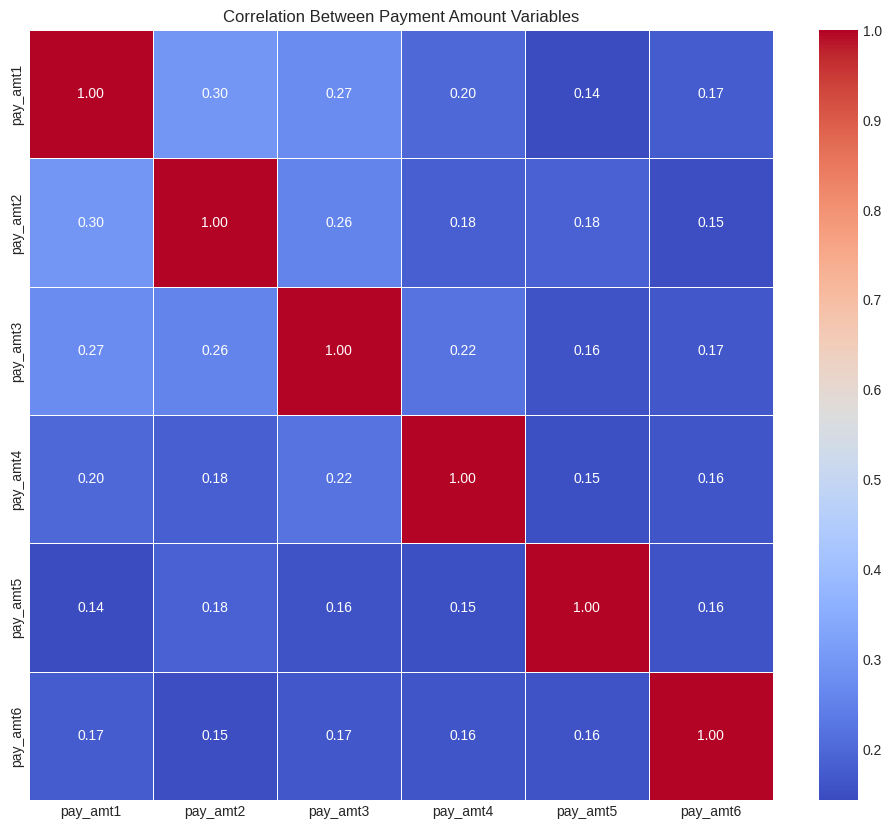

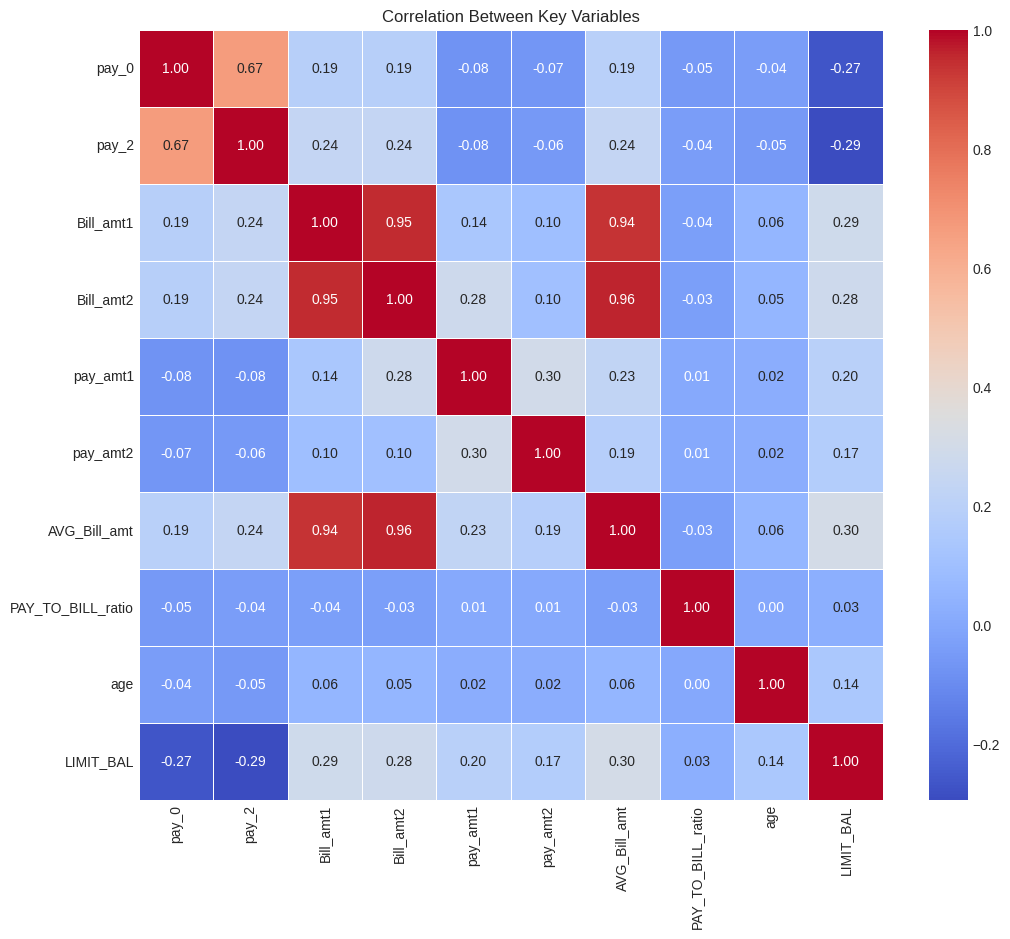

In [60]:
# Let's analyze the payment patterns more deeply

# Create a correlation heatmap for payment status variables
plt.figure(figsize=(12, 10))
corr_pay = df_test[pay_cols].corr()
sns.heatmap(corr_pay, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Between Payment Status Variables')
plt.show()

# Create a correlation heatmap for bill amounts
plt.figure(figsize=(12, 10))
corr_bill = df_test[bill_cols].corr()
sns.heatmap(corr_bill, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Between Bill Amount Variables')
plt.show()

# Create a correlation heatmap for payment amounts
plt.figure(figsize=(12, 10))
corr_pay_amt = df_test[pay_amt_cols].corr()
sns.heatmap(corr_pay_amt, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Between Payment Amount Variables')
plt.show()

# Calculate correlation between payment status and bill/payment amounts
selected_cols = ['pay_0', 'pay_2', 'Bill_amt1', 'Bill_amt2', 'pay_amt1', 'pay_amt2', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'age', 'LIMIT_BAL']
plt.figure(figsize=(12, 10))
corr_selected = df_test[selected_cols].corr()
sns.heatmap(corr_selected, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Between Key Variables')
plt.show()

# Initial model(original features)

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define features and target
X = df_test.drop(['Customer_ID', 'next_month_default'], axis=1)
y = df_test['next_month_default']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Train, Predict, Evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    report = classification_report(y_val, y_pred, output_dict=True)
    auc = roc_auc_score(y_val, y_prob)

    print(f"\n==================== {name} ====================")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))
    print(f"ROC AUC Score: {auc:.4f}")

    results.append({
        "Model": name,
        "Precision (1)": report['1']['precision'],
        "Recall (1)": report['1']['recall'],
        "F1-score (1)": report['1']['f1-score'],
        "ROC AUC": auc
    })

# Comparison Table
comparison_df = pd.DataFrame(results)
print("\n\n===== Model Comparison =====")
print(comparison_df.sort_values(by="ROC AUC", ascending=False).round(4))




==================== Logistic Regression ====================
Confusion Matrix:
 [[4067    1]
 [ 957    0]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8095    0.9998    0.8946      4068
           1     0.0000    0.0000    0.0000       957

    accuracy                         0.8094      5025
   macro avg     0.4048    0.4999    0.4473      5025
weighted avg     0.6553    0.8094    0.7243      5025

ROC AUC Score: 0.6450

==================== Random Forest ====================
Confusion Matrix:
 [[3882  186]
 [ 646  311]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8573    0.9543    0.9032      4068
           1     0.6258    0.3250    0.4278       957

    accuracy                         0.8344      5025
   macro avg     0.7415    0.6396    0.6655      5025
weighted avg     0.8132    0.8344    0.8127      5025

ROC AUC Score: 0.7652

==================== XGBoost ==========

This one was without using smote.

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

# Prepare the data
df = df_test.copy()
X = df.drop(['Customer_ID', 'next_month_default'], axis=1)
y = df['next_month_default']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Train and evaluate
results = {}

for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_train_sm, y_train_sm)  # pipeline will scale automatically
        y_pred = model.predict(X_val)
    else:
        model.fit(X_train_sm, y_train_sm)  # no scaling for tree-based models
        y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

    results[name] = {
        "Accuracy": accuracy,
        "Precision (1)": report['1']['precision'],
        "Recall (1)": report['1']['recall'],
        "F1-Score (1)": report['1']['f1-score']
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


[LightGBM] [Info] Number of positive: 16289, number of negative: 16289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4153
[LightGBM] [Info] Number of data points in the train set: 32578, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                     Accuracy  Precision (1)  Recall (1)  F1-Score (1)
Logistic Regression  0.694527       0.330704    0.557830      0.415238
Random Forest        0.799403       0.481526    0.413511      0.444934
XGBoost              0.810149       0.515775    0.384852      0.440797
LightGBM             0.816119       0.537377    0.389969      0.451957


We can use a significant improvement in recall after using smote

# Feature Engineering

In [67]:
# Make a copy of the dataset to avoid modifying the original
df_test_engineered = df_test.copy()

# 1. Credit Utilization Ratio - How much of the credit limit is being used
df_test_engineered['credit_utilization'] = df_test_engineered['Bill_amt1'] / df_test_engineered['LIMIT_BAL']
df_test_engineered['credit_utilization'] = df_test_engineered['credit_utilization'].clip(0, 5)  # Clip outliers

# 2. Payment consistency - Variance in payment status over time
df_test_engineered['payment_consistency'] = df_test_engineered[pay_cols].var(axis=1)

# 3. Delinquency streak - Count of consecutive months with payment delays
def count_delinquency_streak(row):
    streak = 0
    for col in ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']:
        if row[col] > 0:  # payment delay
            streak += 1
        else:
            break  # Break on first non-delay
    return streak
df_test_engineered['delinquency_streak'] = df_test_engineered.apply(count_delinquency_streak, axis=1)

# 4. Payment ratio trend - Is the customer increasing or decreasing their payment to bill ratio?
df_test_engineered['pay_ratio_1'] = df_test_engineered['pay_amt1'] / (df_test_engineered['Bill_amt1'] + 1)  # Add 1 to avoid division by zero
df_test_engineered['pay_ratio_2'] = df_test_engineered['pay_amt2'] / (df_test_engineered['Bill_amt2'] + 1)
df_test_engineered['pay_ratio_3'] = df_test_engineered['pay_amt3'] / (df_test_engineered['Bill_amt3'] + 1)
df_test_engineered['pay_ratio_trend'] = df_test_engineered['pay_ratio_1'] - df_test_engineered['pay_ratio_3']

# 5. Risk level based on payment history - Number of months with payment delays
df_test_engineered['payment_delay_count'] = (df_test_engineered[pay_cols] > 0).sum(axis=1)

# 6. Full payment count - Number of months with full payment
df_test_engineered['full_payment_count'] = (df_test_engineered[pay_cols] == -1).sum(axis=1)

# 7. No consumption count - Number of months with no consumption
df_test_engineered['no_consumption_count'] = (df_test_engineered[pay_cols] == -2).sum(axis=1)

# 8. Minimum payment pattern - Number of months with minimum payment
df_test_engineered['minimum_payment_count'] = (df_test_engineered[pay_cols] == 0).sum(axis=1)

# 9. Payment to bill ratio volatility - Measures the inconsistency in payment behavior
pay_ratio_cols = ['pay_ratio_1', 'pay_ratio_2', 'pay_ratio_3']
df_test_engineered['pay_ratio_volatility'] = df_test_engineered[pay_ratio_cols].std(axis=1)

# 10. Recent delinquency - Whether there was a payment delay in the last two months
df_test_engineered['recent_delinquency'] = ((df_test_engineered['pay_0'] > 0) | (df_test_engineered['pay_2'] > 0)).astype(int)

# Display the first rows of the engineered dataset
print("Engineered features added:")
print(df_test_engineered.columns.tolist())
df_test_engineered[['Customer_ID', 'credit_utilization', 'payment_consistency', 'delinquency_streak',
                   'pay_ratio_trend', 'payment_delay_count', 'full_payment_count',
                   'no_consumption_count', 'recent_delinquency']].head(10)

Engineered features added:
['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default', 'credit_utilization', 'payment_consistency', 'delinquency_streak', 'pay_ratio_1', 'pay_ratio_2', 'pay_ratio_3', 'pay_ratio_trend', 'payment_delay_count', 'full_payment_count', 'no_consumption_count', 'minimum_payment_count', 'pay_ratio_volatility', 'recent_delinquency']


,Customer_ID,credit_utilization,payment_consistency,delinquency_streak,pay_ratio_trend,payment_delay_count,full_payment_count,no_consumption_count,recent_delinquency
0,5017,1.005398,1.200000,3,0.013062,3,0,0,1
1,5018,0.038475,0.966667,0,0.000000,0,1,2,0
2,5019,0.266283,0.000000,0,0.006652,0,0,0,0
3,5020,0.434059,0.000000,0,-0.000780,0,0,0,0
4,5021,0.070237,0.000000,0,-14.075617,0,0,6,0
5,5022,0.045185,1.500000,0,-0.239260,1,5,0,1
6,5023,0.146560,0.266667,0,-0.944466,0,4,0,0
7,5024,0.818054,0.000000,0,-0.016021,0,0,0,0
8,5025,0.927256,0.000000,0,-0.006986,0,0,0,0
10,5027,0.000000,0.966667,1,1071.462983,1,4,1,1


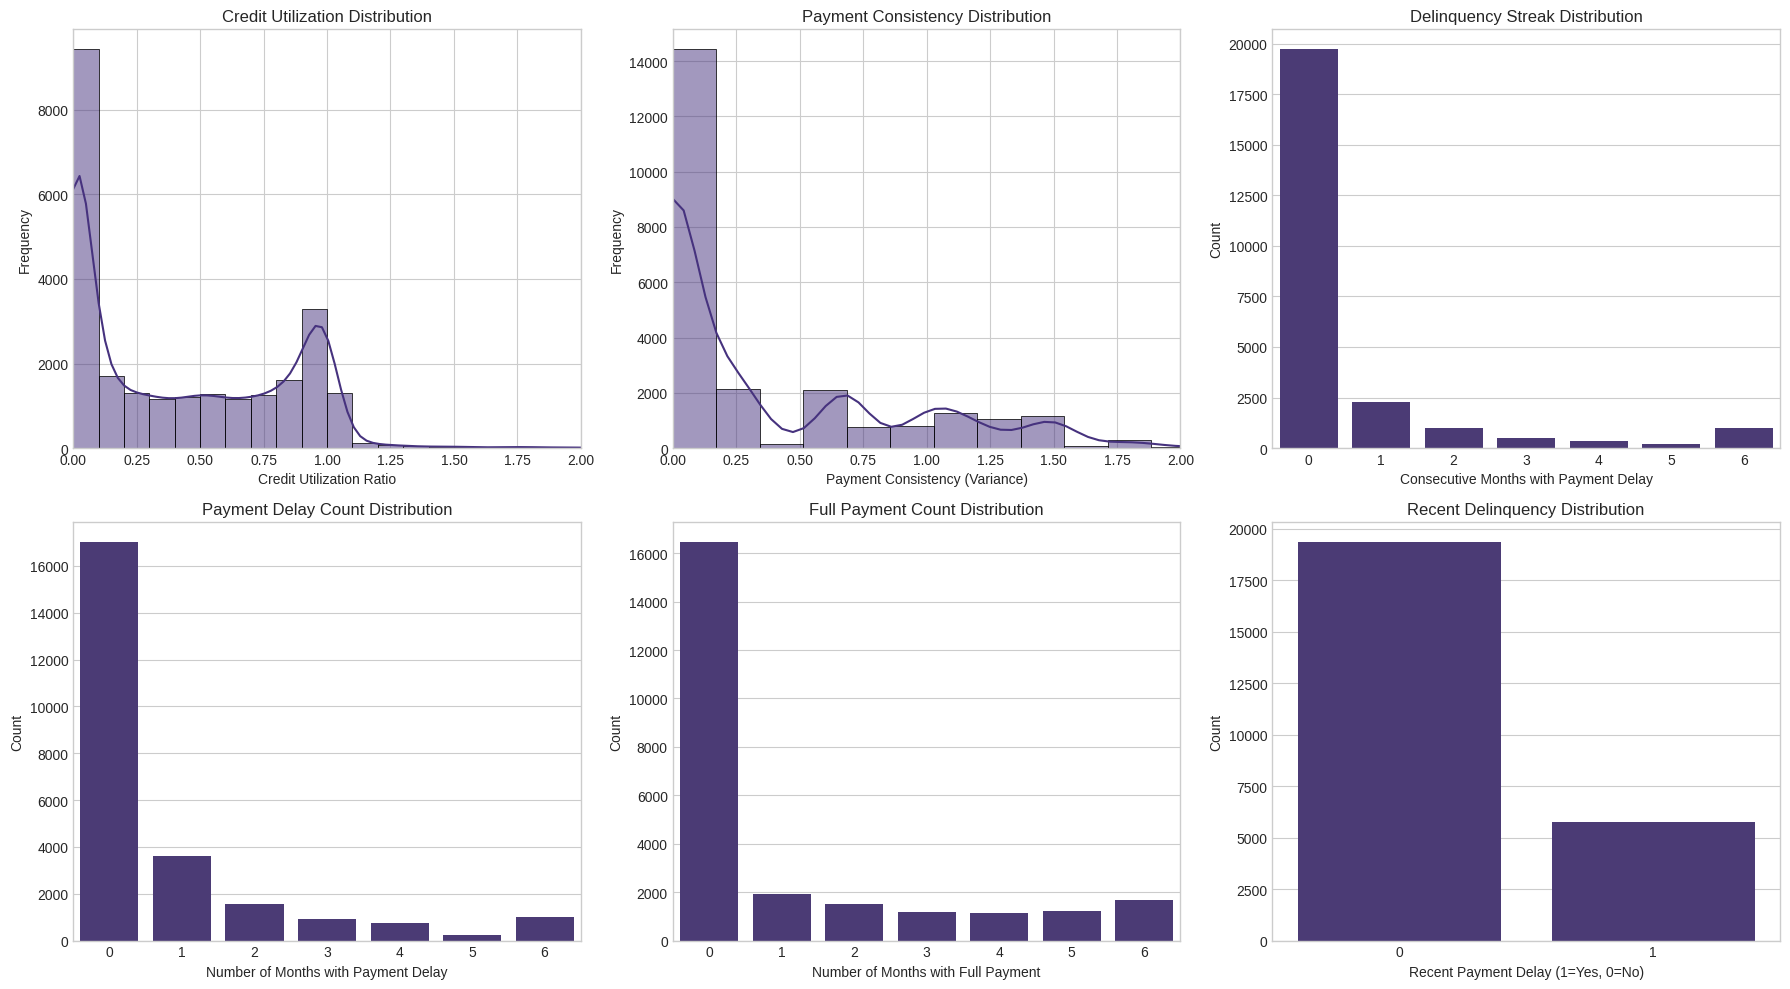

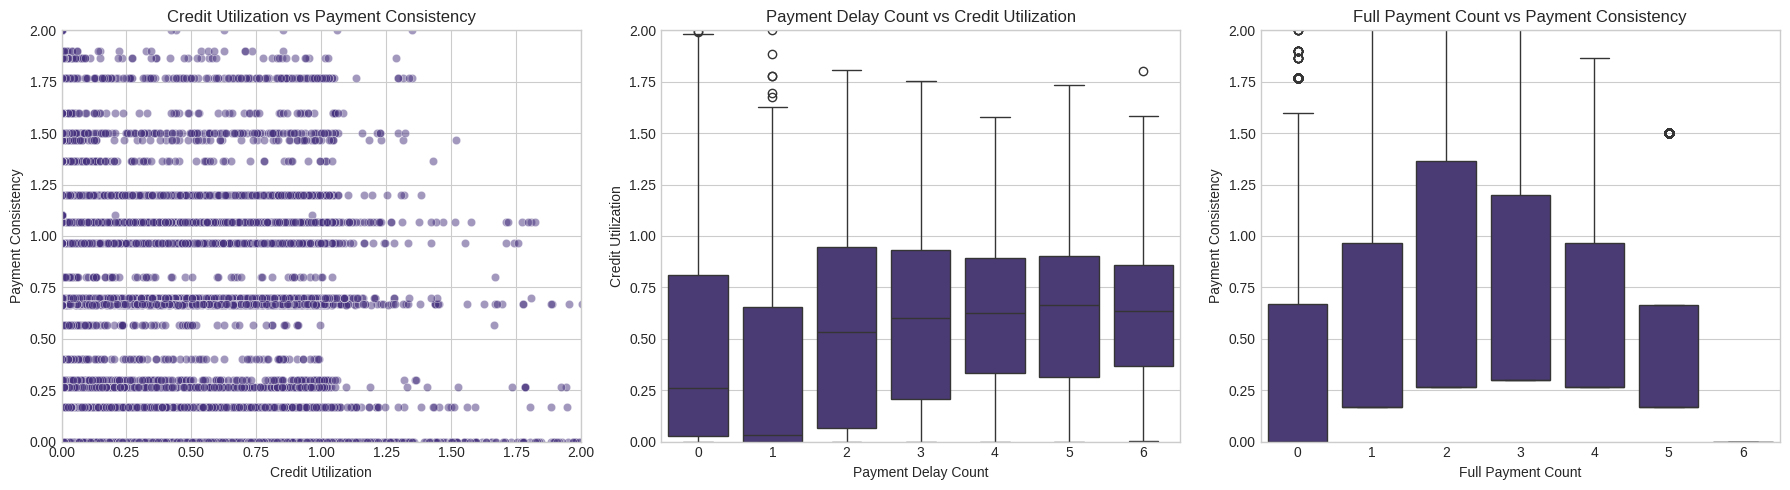

In [68]:
# Let's visualize some of the new engineered features

# 1. Credit utilization distribution
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.histplot(df_test_engineered['credit_utilization'], bins=50, kde=True)
plt.title('Credit Utilization Distribution')
plt.xlabel('Credit Utilization Ratio')
plt.ylabel('Frequency')
plt.xlim(0, 2)  # Limit to meaningful range

# 2. Payment consistency
plt.subplot(2, 3, 2)
sns.histplot(df_test_engineered['payment_consistency'], bins=50, kde=True)
plt.title('Payment Consistency Distribution')
plt.xlabel('Payment Consistency (Variance)')
plt.ylabel('Frequency')
plt.xlim(0, 2)

# 3. Delinquency streak
plt.subplot(2, 3, 3)
sns.countplot(data=df_test_engineered, x='delinquency_streak')
plt.title('Delinquency Streak Distribution')
plt.xlabel('Consecutive Months with Payment Delay')
plt.ylabel('Count')

# 4. Payment delay count
plt.subplot(2, 3, 4)
sns.countplot(data=df_test_engineered, x='payment_delay_count')
plt.title('Payment Delay Count Distribution')
plt.xlabel('Number of Months with Payment Delay')
plt.ylabel('Count')

# 5. Full payment count
plt.subplot(2, 3, 5)
sns.countplot(data=df_test_engineered, x='full_payment_count')
plt.title('Full Payment Count Distribution')
plt.xlabel('Number of Months with Full Payment')
plt.ylabel('Count')

# 6. Recent delinquency
plt.subplot(2, 3, 6)
sns.countplot(data=df_test_engineered, x='recent_delinquency')
plt.title('Recent Delinquency Distribution')
plt.xlabel('Recent Payment Delay (1=Yes, 0=No)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Relationship between features
plt.figure(figsize=(18, 5))

# Credit utilization vs Payment consistency
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_test_engineered, x='credit_utilization', y='payment_consistency', alpha=0.5)
plt.title('Credit Utilization vs Payment Consistency')
plt.xlabel('Credit Utilization')
plt.ylabel('Payment Consistency')
plt.xlim(0, 2)
plt.ylim(0, 2)

# Payment delay count vs Credit utilization
plt.subplot(1, 3, 2)
sns.boxplot(data=df_test_engineered, x='payment_delay_count', y='credit_utilization')
plt.title('Payment Delay Count vs Credit Utilization')
plt.xlabel('Payment Delay Count')
plt.ylabel('Credit Utilization')
plt.ylim(0, 2)

# Full payment count vs Payment consistency
plt.subplot(1, 3, 3)
sns.boxplot(data=df_test_engineered, x='full_payment_count', y='payment_consistency')
plt.title('Full Payment Count vs Payment Consistency')
plt.xlabel('Full Payment Count')
plt.ylabel('Payment Consistency')
plt.ylim(0, 2)

plt.tight_layout()
plt.show()

# New model (Using engineered features)


Logistic Regression Performance:
F1 Score: 0.4882
F2 Score: 0.5421
AUC-ROC: 0.7568

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      4068
           1       0.42      0.59      0.49       957

    accuracy                           0.77      5025
   macro avg       0.66      0.70      0.67      5025
weighted avg       0.80      0.77      0.78      5025



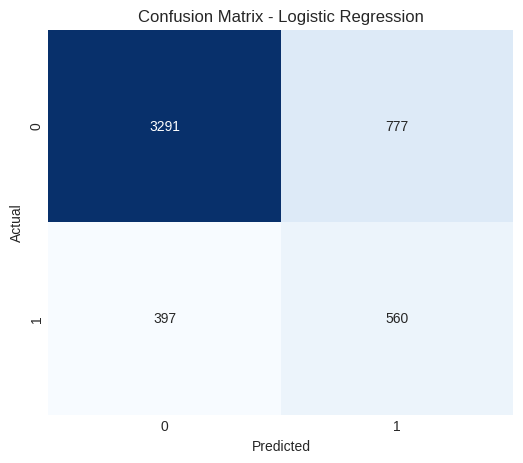


Random Forest Performance:
F1 Score: 0.4747
F2 Score: 0.4505
AUC-ROC: 0.7601

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4068
           1       0.52      0.44      0.47       957

    accuracy                           0.82      5025
   macro avg       0.70      0.67      0.68      5025
weighted avg       0.81      0.82      0.81      5025



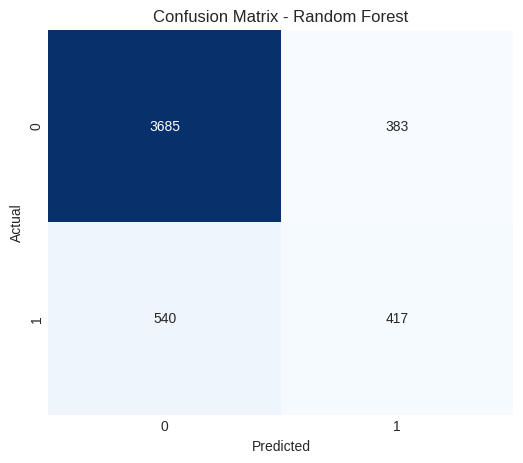


XGBoost Performance:
F1 Score: 0.4466
F2 Score: 0.5407
AUC-ROC: 0.7362

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80      4068
           1       0.35      0.63      0.45       957

    accuracy                           0.70      5025
   macro avg       0.62      0.67      0.62      5025
weighted avg       0.79      0.70      0.73      5025



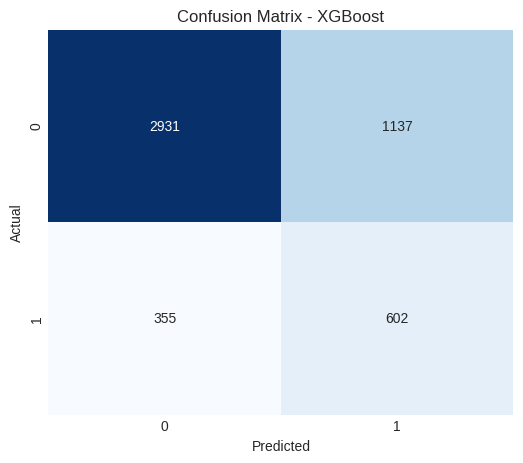

[LightGBM] [Info] Number of positive: 16269, number of negative: 16269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9289
[LightGBM] [Info] Number of data points in the train set: 32538, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Performance:
F1 Score: 0.4874
F2 Score: 0.4404
AUC-ROC: 0.7612

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4068
           1       0.59      0.41      0.49       957

    accuracy                           0.83      5025
   macro avg       0.73      0.67      0.69      5025
weighted avg       0.82      0.83      0.82      5025



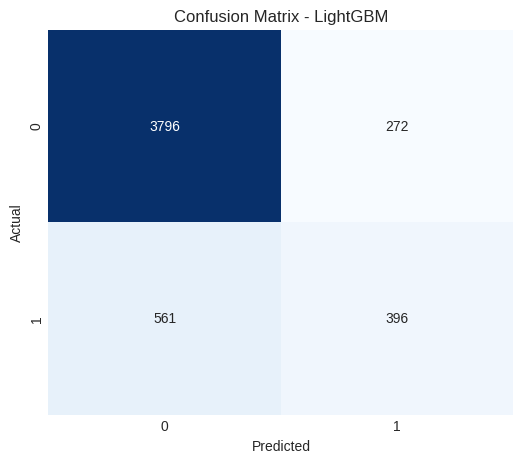

Model Comparison:
                 Model  F2 Score   AUC-ROC
0  Logistic Regression  0.542110  0.756768
2              XGBoost  0.540686  0.736240
1        Random Forest  0.450519  0.760069
3             LightGBM  0.440391  0.761168


In [71]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    fbeta_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# Drop identifier and define target
df = df_test_engineered.copy()
df.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df.drop(columns=[target])
y = df[target]

# scale features for models like Logistic Regression
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE for imbalance handling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Evaluation Function
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1]
        auc_roc = roc_auc_score(y, y_scores)
    else:
        auc_roc = None

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    if auc_roc:
        print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

# Train & Evaluate Models
models = []

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_smote, y_train_smote)
lr_f2, lr_auc, _ = evaluate_model(lr, X_val, y_val, "Logistic Regression")
models.append(("Logistic Regression", lr_f2, lr_auc, lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_smote, y_train_smote)
rf_f2, rf_auc, _ = evaluate_model(rf, X_val, y_val, "Random Forest")
models.append(("Random Forest", rf_f2, rf_auc, rf))

# XGBoost
xgb_model = xgb.XGBClassifier(scale_pos_weight=5, n_estimators=100, random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)
xgb_f2, xgb_auc, _ = evaluate_model(xgb_model, X_val, y_val, "XGBoost")
models.append(("XGBoost", xgb_f2, xgb_auc, xgb_model))

# LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lgb_model.fit(X_train_smote, y_train_smote)
lgb_f2, lgb_auc, _ = evaluate_model(lgb_model, X_val, y_val, "LightGBM")
models.append(("LightGBM", lgb_f2, lgb_auc, lgb_model))

# Compare Models
models_df = pd.DataFrame(models, columns=['Model', 'F2 Score', 'AUC-ROC', 'Model Object'])
print("Model Comparison:")
print(models_df[['Model', 'F2 Score', 'AUC-ROC']].sort_values(by='F2 Score', ascending=False))


Clear improvement than just original features

# Trying weighted ensemble

With original features without SMOTE.

Generally used :-
Normalized weights = F2/ sum of all F2s

[LightGBM] [Info] Number of positive: 3827, number of negative: 16269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3769
[LightGBM] [Info] Number of data points in the train set: 20096, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190436 -> initscore=-1.447180
[LightGBM] [Info] Start training from score -1.447180

📊 Weighted Ensemble Performance:
F1 Score: 0.4226
F2 Score: 0.3488
AUC-ROC: 0.7703

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4068
           1       0.65      0.31      0.42       957

    accuracy                           0.84      5025
   macro avg       0.75      0.64      0.66      5025
weighted avg       0.82      0.84      0.81      5025



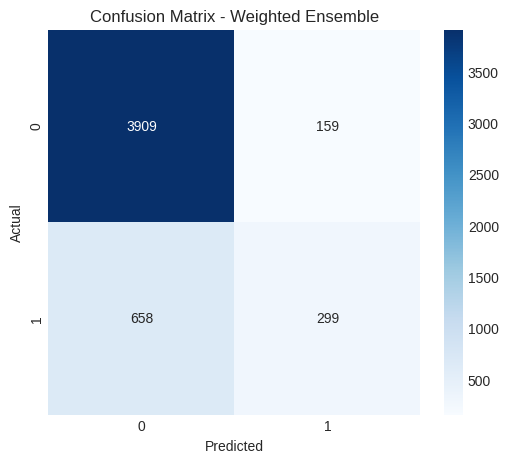

In [76]:

# Copy from df_test to preserve original
df2 = df_test.copy()

# Drop identifier column (if present)
df2.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

# Define target
target = 'next_month_default'
X = df2.drop(columns=[target])
y = df2[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale only for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train models
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = LGBMClassifier(random_state=42)

# Train
lr.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Predict probabilities
lr_probs = lr.predict_proba(X_val_scaled)[:, 1]
rf_probs = rf.predict_proba(X_val)[:, 1]
xgb_probs = xgb_model.predict_proba(X_val)[:, 1]
lgb_probs = lgb_model.predict_proba(X_val)[:, 1]

# Weighted ensemble
weights = {
    'xgb': 0.2,
    'lr': 0.3,
    'rf': 0.3,
    'lgb': 0.2
}

ensemble_probs = (
    weights['lr'] * lr_probs +
    weights['rf'] * rf_probs +
    weights['xgb'] * xgb_probs +
    weights['lgb'] * lgb_probs
)

# Convert probabilities to class labels using 0.5 threshold
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# Evaluate
f1_ensemble = f1_score(y_val, ensemble_preds)
f2_ensemble = fbeta_score(y_val, ensemble_preds, beta=2)
auc_ensemble = roc_auc_score(y_val, ensemble_probs)

print("\n📊 Weighted Ensemble Performance:")
print(f"F1 Score: {f1_ensemble:.4f}")
print(f"F2 Score: {f2_ensemble:.4f}")
print(f"AUC-ROC: {auc_ensemble:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, ensemble_preds))

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, ensemble_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Weighted Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Conclusion :- Without SMOTE(or data balancing) and feature engineering , the models generally dont give good results, with whatever tweaking of hyperparameters.

# Using SHAP

First using top 10 features from original features and only lightgbm
then using top k(5 to 15) features from original features and only lightgbm , then using top  k (k= 5 to 15) features from engineered+original features and across all 4 (lightgbm, xgboost,logistic regression,random forest) and then selecting the best .

In [77]:
!pip install shap --quiet


[LightGBM] [Info] Number of positive: 3845, number of negative: 16352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3767
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


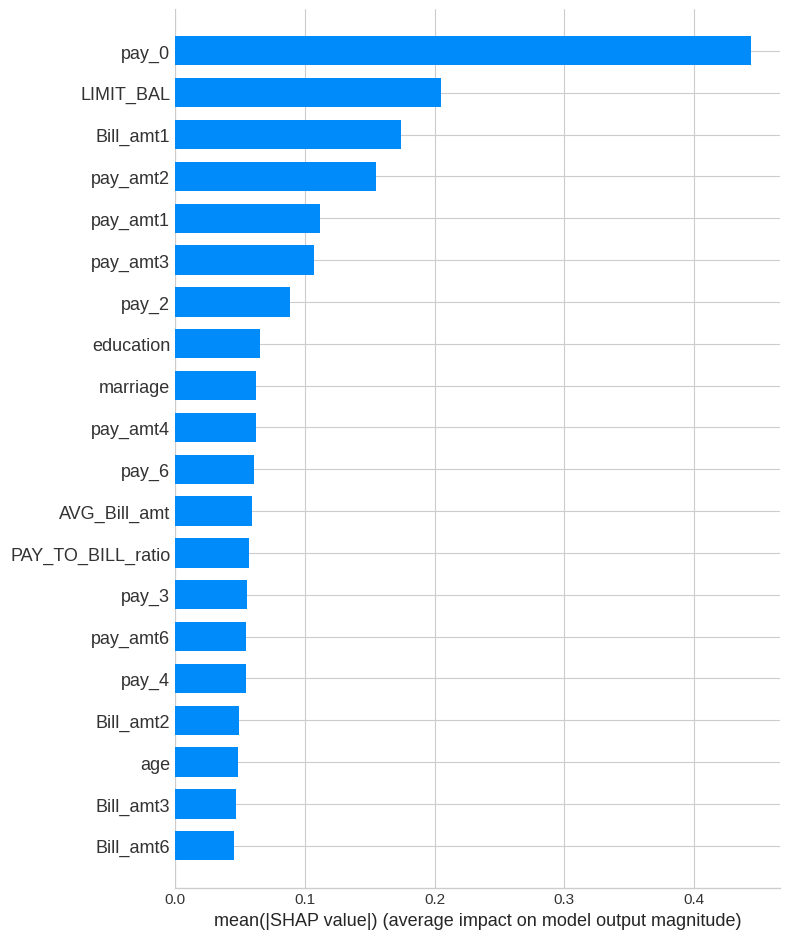


Top 10 features based on SHAP mean absolute value:
pay_0        0.444123
LIMIT_BAL    0.205151
Bill_amt1    0.174357
pay_amt2     0.154596
pay_amt1     0.111804
pay_amt3     0.107105
pay_2        0.088355
education    0.065602
marriage     0.062396
pay_amt4     0.062197
dtype: float64


In [78]:

# Imports
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score
import lightgbm as lgb

# Load dataset
df = pd.read_csv("/content/trainset_creditcard.csv")

# Preprocessing
df['age'] = df['age'].fillna(df['age'].median())
df.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lgb_model.fit(X_train, y_train)

# SHAP Analysis
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_val)

# Summary plot (bar chart for top features)
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Show top-K features numerically
shap_df = pd.DataFrame(shap_values, columns=X_val.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

K = 10
print(f"\nTop {K} features based on SHAP mean absolute value:")
print(mean_abs_shap.head(K))


[LightGBM] [Info] Number of positive: 3845, number of negative: 16352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3767
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


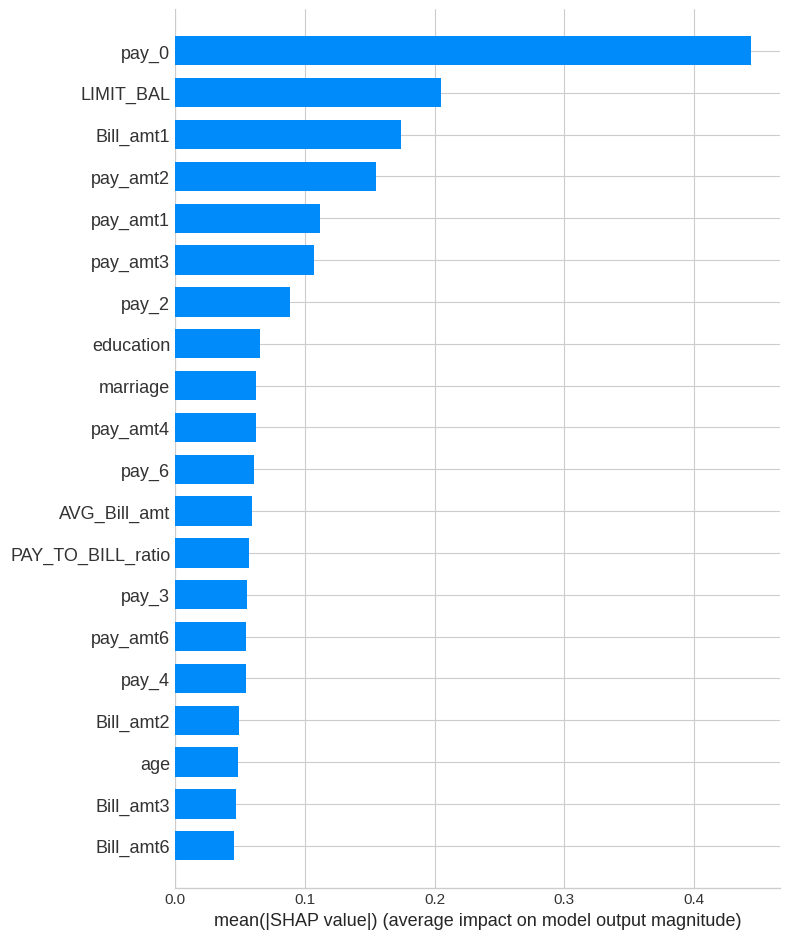


Top 10 features based on SHAP mean absolute value:
pay_0        0.444123
LIMIT_BAL    0.205151
Bill_amt1    0.174357
pay_amt2     0.154596
pay_amt1     0.111804
pay_amt3     0.107105
pay_2        0.088355
education    0.065602
marriage     0.062396
pay_amt4     0.062197
dtype: float64
[LightGBM] [Info] Number of positive: 3845, number of negative: 16352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3845, number of negative: 16352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

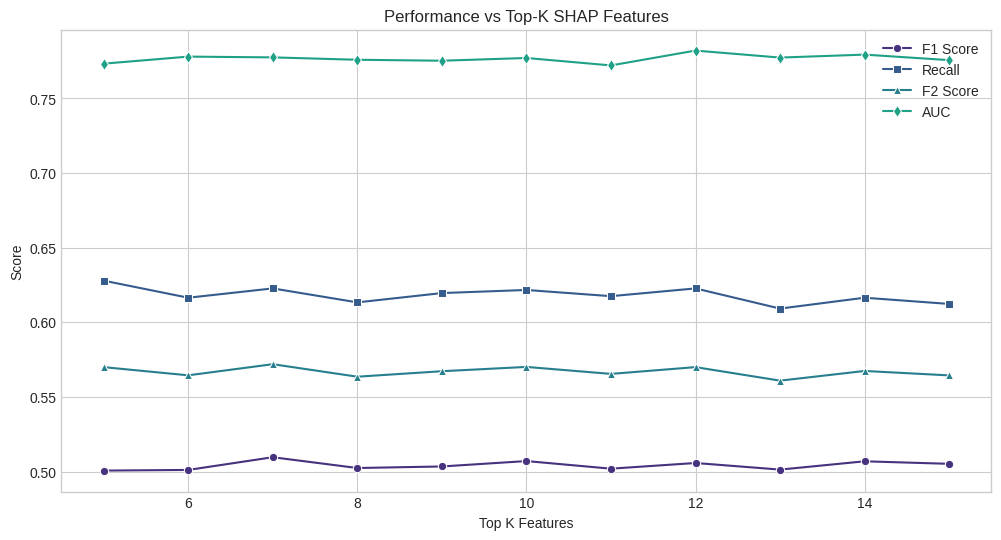

In [79]:
# Imports
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, roc_auc_score, fbeta_score
import lightgbm as lgb

# Load dataset
df = pd.read_csv("/content/trainset_creditcard.csv")

# Preprocessing
df['age'] = df['age'].fillna(df['age'].median())
df.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train initial LightGBM model on full features
lgb_model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lgb_model.fit(X_train, y_train)

# SHAP analysis
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_val)

# Plot summary bar chart
shap.summary_plot(shap_values, X_val, plot_type="bar")

# SHAP importance ranking
shap_df = pd.DataFrame(shap_values, columns=X_val.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# Display Top-10 features
print("\nTop 10 features based on SHAP mean absolute value:")
print(mean_abs_shap.head(10))

# Evaluate model using top-K features (from 5 to 15)
results = []

for K in range(5, 16):
    top_k_features = mean_abs_shap.head(K).index.tolist()

    # Subset data
    X_train_k = X_train[top_k_features]
    X_val_k = X_val[top_k_features]

    # Train model on top-K features
    model_k = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model_k.fit(X_train_k, y_train)

    # Predict and evaluate
    preds_k = model_k.predict(X_val_k)
    probas_k = model_k.predict_proba(X_val_k)[:, 1]

    f1 = f1_score(y_val, preds_k)
    recall = recall_score(y_val, preds_k)
    f2 = fbeta_score(y_val, preds_k, beta=2)
    auc = roc_auc_score(y_val, probas_k)

    results.append({
        'Top_K_Features': K,
        'F1_Score': f1,
        'Recall': recall,
        'F2_Score': f2,
        'AUC': auc
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Show results
print("\n📊 Model performance using Top-K SHAP Features:")
print(results_df)

# Plot performance metrics
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Top_K_Features', y='F1_Score', marker='o', label='F1 Score')
sns.lineplot(data=results_df, x='Top_K_Features', y='Recall', marker='s', label='Recall')
sns.lineplot(data=results_df, x='Top_K_Features', y='F2_Score', marker='^', label='F2 Score')
sns.lineplot(data=results_df, x='Top_K_Features', y='AUC', marker='d', label='AUC')
plt.title("Performance vs Top-K SHAP Features")
plt.xlabel("Top K Features")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()


[LightGBM] [Info] Number of positive: 3827, number of negative: 16269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5392
[LightGBM] [Info] Number of data points in the train set: 20096, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 3827, number of negative: 16269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 20096, number of used features: 5
[LightGBM] [Info] [binar

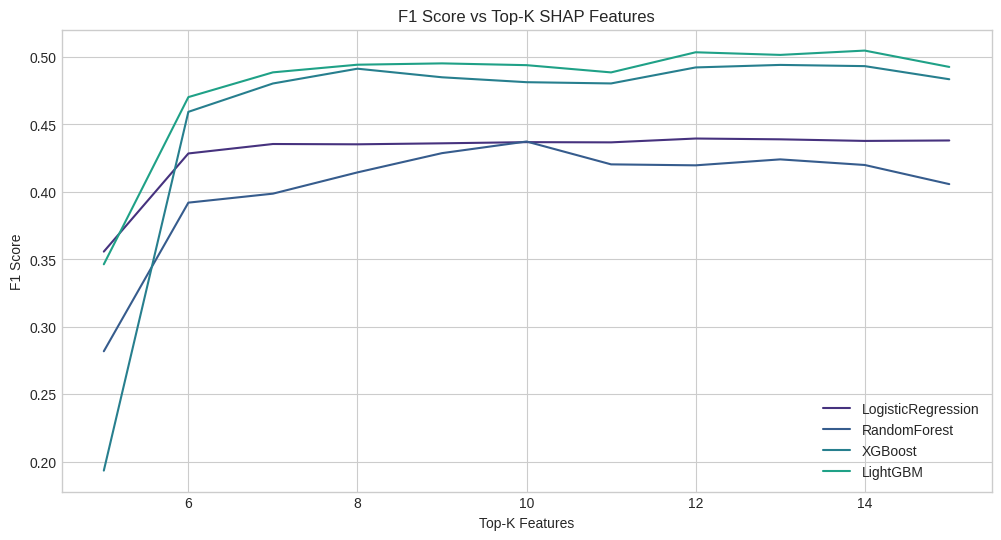

In [83]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, fbeta_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Assume df4 is your feature-engineered dataset
df = df_test_engineered.copy()
df.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df.drop(columns=[target])
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train LightGBM for SHAP values
lgb_model_for_shap = LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lgb_model_for_shap.fit(X_train, y_train)

explainer = shap.TreeExplainer(lgb_model_for_shap)
shap_values = explainer.shap_values(X_val)[1]

# Mean absolute SHAP value per feature
mean_abs_shap = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

top_features_ranked = mean_abs_shap['feature'].values

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=2, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

results = []

for k in range(5, 16):
    top_k_features = top_features_ranked[:k]
    X_train_k = X_train[top_k_features]
    X_val_k = X_val[top_k_features]

    X_train_k_scaled = scaler.fit_transform(X_train_k)
    X_val_k_scaled = scaler.transform(X_val_k)

    for name, model in models.items():
        if name == 'LogisticRegression':
            model.fit(X_train_k_scaled, y_train)
            preds = model.predict(X_val_k_scaled)
            probs = model.predict_proba(X_val_k_scaled)[:, 1]
        else:
            model.fit(X_train_k, y_train)
            preds = model.predict(X_val_k)
            probs = model.predict_proba(X_val_k)[:, 1]

        f1 = f1_score(y_val, preds)
        recall = recall_score(y_val, preds)
        f2 = fbeta_score(y_val, preds, beta=2)
        auc = roc_auc_score(y_val, probs)

        results.append({
            'Model': name,
            'Top_K_Features': k,
            'F1_Score': round(f1, 6),
            'Recall': round(recall, 6),
            'F2_Score': round(f2, 6),
            'AUC': round(auc, 6)
        })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print("\n📊 Model performance using Top-K SHAP Features:")
print(results_df.sort_values(['Top_K_Features', 'Model']))

# Optional: Plotting F1 score vs K for each model
plt.figure(figsize=(12, 6))
for model in results_df['Model'].unique():
    subset = results_df[results_df['Model'] == model]
    plt.plot(subset['Top_K_Features'], subset['F1_Score'], label=model)
plt.title('F1 Score vs Top-K SHAP Features')
plt.xlabel('Top-K Features')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


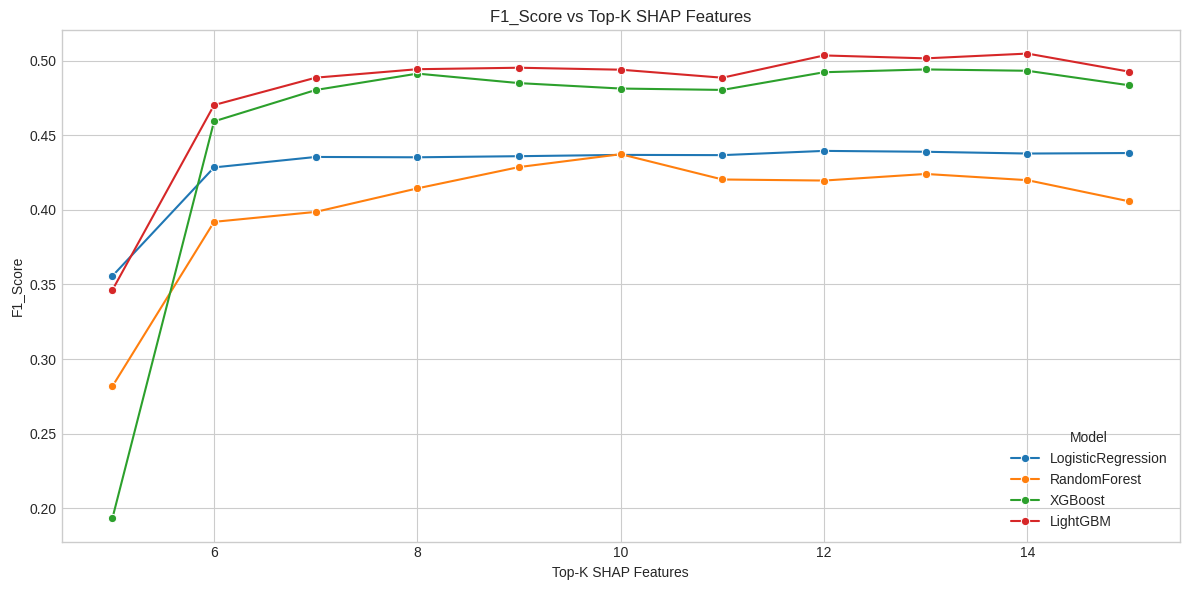

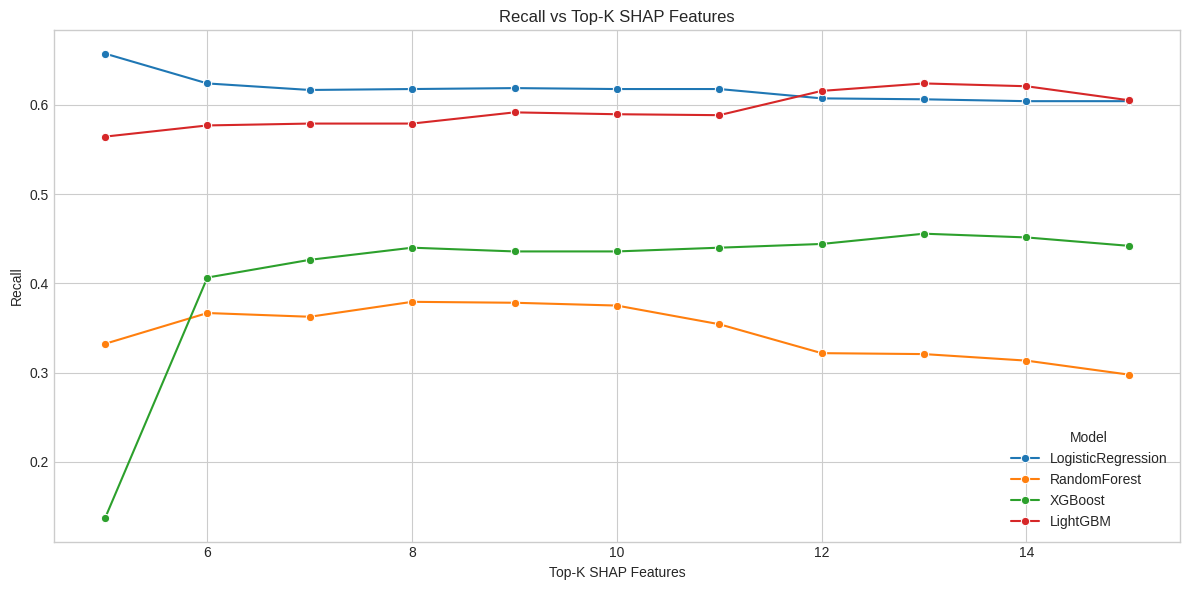

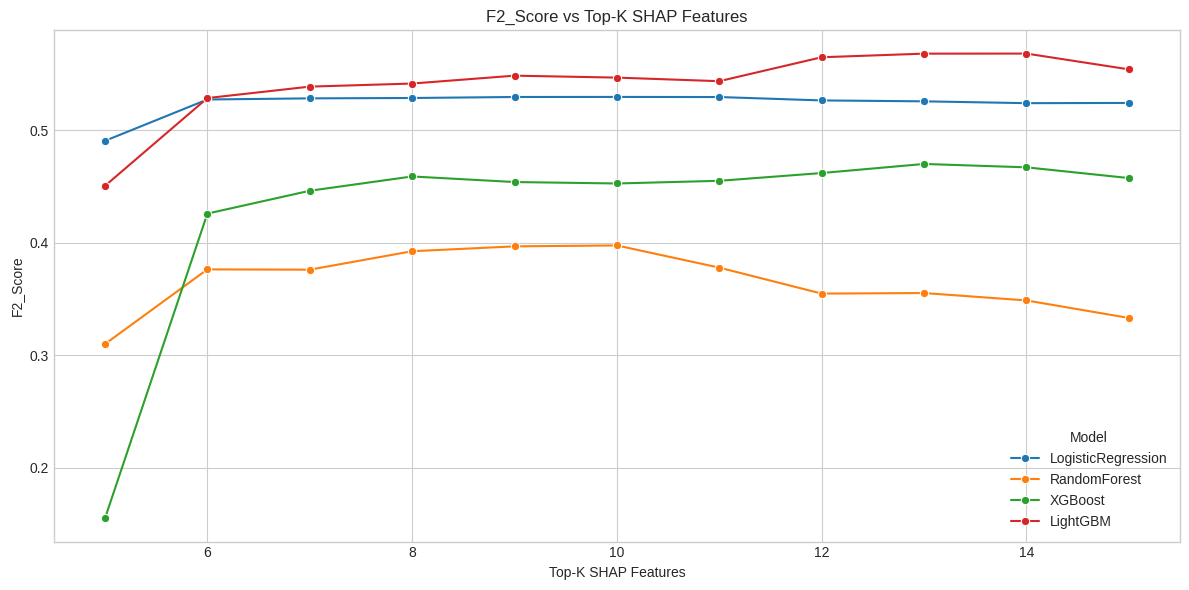

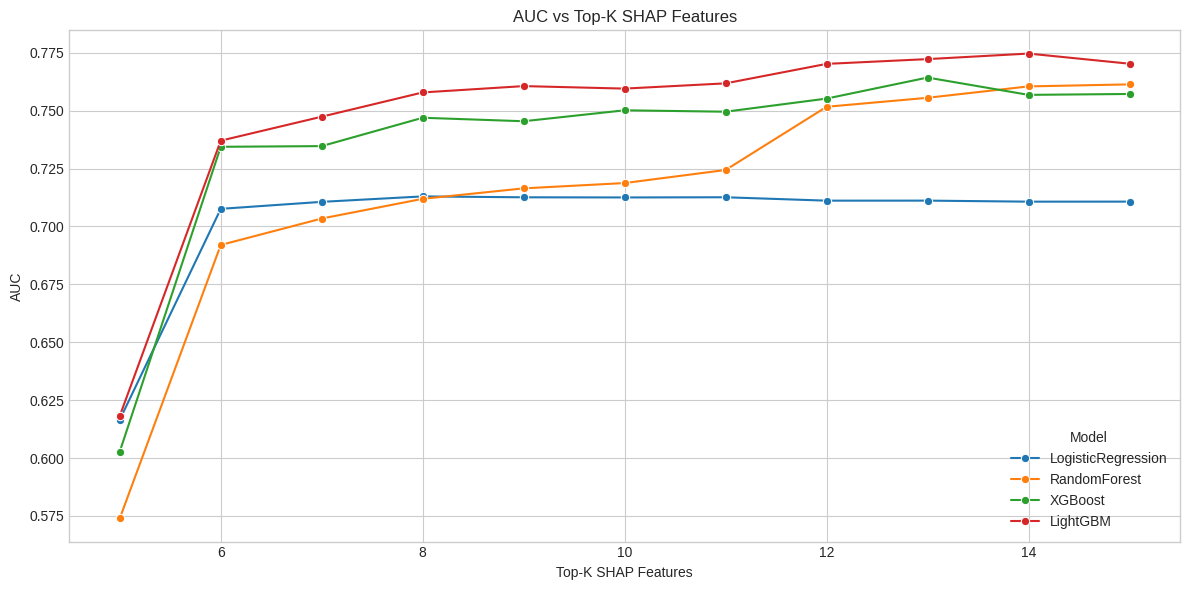

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['F1_Score', 'Recall', 'F2_Score', 'AUC']
palette = sns.color_palette("tab10", 4)

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results_df, x='Top_K_Features', y=metric, hue='Model', palette=palette, marker='o')
    plt.title(f'{metric} vs Top-K SHAP Features')
    plt.xlabel('Top-K SHAP Features')
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


In [85]:
for metric in ['F1_Score', 'F2_Score', 'AUC']:
    best_row = results_df.loc[results_df[metric].idxmax()]
    print(f"🔹 Best {metric}:")
    print(best_row)
    print()


🔹 Best F1_Score:
Model             LightGBM
Top_K_Features          14
F1_Score          0.504673
Recall             0.62069
F2_Score          0.568421
AUC               0.774623
Name: 39, dtype: object

🔹 Best F2_Score:
Model             LightGBM
Top_K_Features          14
F1_Score          0.504673
Recall             0.62069
F2_Score          0.568421
AUC               0.774623
Name: 39, dtype: object

🔹 Best AUC:
Model             LightGBM
Top_K_Features          14
F1_Score          0.504673
Recall             0.62069
F2_Score          0.568421
AUC               0.774623
Name: 39, dtype: object



So, improvement in value of F2 score from 0.54 to 0.56

# Using automl

I am using this to generate the predictions file since this is the one which can give maximum f2 score if we pay less attention to interpretability.

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.9 MB/s eta 0:00:00


In [ ]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd


In [ ]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppkze3n34
  JVM stdout: /tmp/tmppkze3n34/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppkze3n34/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 20 days
H2O_cluster_name:,H2O_from_python_unknownUser_18asmk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
train_df = pd.read_csv('/content/trainset_creditcard.csv')
test_df = pd.read_csv('/content/testset_creditcard.csv')

In [ ]:
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Defining target and features
target = "next_month_default"
train_h2o[target] = train_h2o[target].asfactor()
features = [col for col in train_h2o.columns if col not in [target, "Customer_ID"]]

In [ ]:
# Run AutoML
aml = H2OAutoML(max_runtime_secs=600, seed=1, nfolds=5)
aml.train(x=features, y=target, training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [ ]:
aml.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_2_20250616_162113,0.784902,0.393111,0.523739,0.287781,0.347837,0.120991
StackedEnsemble_AllModels_3_AutoML_2_20250616_162113,0.784569,0.393351,0.523652,0.292209,0.34788,0.12102
StackedEnsemble_AllModels_2_AutoML_2_20250616_162113,0.784538,0.393394,0.524434,0.290261,0.347963,0.121078
StackedEnsemble_BestOfFamily_3_AutoML_2_20250616_162113,0.784342,0.393421,0.524005,0.292888,0.34797,0.121083
StackedEnsemble_AllModels_1_AutoML_2_20250616_162113,0.783553,0.394217,0.521456,0.29351,0.348397,0.121381
StackedEnsemble_BestOfFamily_2_AutoML_2_20250616_162113,0.782881,0.394382,0.521324,0.290344,0.348435,0.121407
GBM_grid_1_AutoML_2_20250616_162113_model_6,0.78214,0.395499,0.515008,0.292806,0.349001,0.121801
StackedEnsemble_BestOfFamily_1_AutoML_2_20250616_162113,0.781254,0.395827,0.517377,0.290147,0.349133,0.121894
GBM_1_AutoML_2_20250616_162113,0.780162,0.396195,0.516375,0.297092,0.349254,0.121978
GBM_grid_1_AutoML_2_20250616_162113_model_2,0.779923,0.396097,0.518168,0.293002,0.348799,0.121661


In [ ]:
preds = aml.leader.predict(test_h2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
# Export predictions with Customer_ID
pred_df = preds.as_data_frame()
final_output = test_df[["Customer_ID"]].copy()
final_output["prediction"] = pred_df["predict"]

# Save predictions to CSV
final_output.to_csv("final_predictions.csv", index=False)

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


# Other models

I have tried ExtraTreeClassifier, then TabNet , then Catboost

In [86]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, recall_score, fbeta_score, roc_auc_score

# Step 1: Create df5 from df_test
df5 = df_test.copy()

# Step 2: Handle missing values (median imputation)
df5.fillna(df5.median(numeric_only=True), inplace=True)

# Step 3: Use only numeric columns
df5 = df5.select_dtypes(include=[np.number])

# Step 4: Define features and target
target_col = 'next_month_default'
if target_col not in df5.columns:
    raise ValueError("Target column not found in df5.")
X = df5.drop(columns=[target_col])
y = df5[target_col]

# Step 5: Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 6: Initialize and train ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model.fit(X_train, y_train)

# Step 7: Predictions
preds = et_model.predict(X_val)
probs = et_model.predict_proba(X_val)[:, 1]

# Step 8: Evaluation
f1 = f1_score(y_val, preds)
recall = recall_score(y_val, preds)
f2 = fbeta_score(y_val, preds, beta=2)
auc = roc_auc_score(y_val, probs)

# Step 9: Show results
print("📊 ExtraTreesClassifier Performance on Original Features:\n")
print(f"F1 Score   : {f1:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F2 Score   : {f2:.4f}")
print(f"ROC-AUC    : {auc:.4f}")


📊 ExtraTreesClassifier Performance on Original Features:

F1 Score   : 0.4259
Recall     : 0.3271
F2 Score   : 0.3605
ROC-AUC    : 0.7713


Not very promising , so i am moving ahead with Tabnet

In [103]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00


epoch 0  | loss: 0.54011 | val_auc: 0.57443 |  0:00:02s
epoch 10 | loss: 0.41106 | val_auc: 0.75468 |  0:00:26s
epoch 20 | loss: 0.40478 | val_auc: 0.76011 |  0:00:49s
epoch 30 | loss: 0.40303 | val_auc: 0.76171 |  0:01:13s
epoch 40 | loss: 0.40051 | val_auc: 0.76427 |  0:01:37s

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_auc = 0.76795

TabNet Performance:
F1 Score: 0.4349
F2 Score: 0.3638
AUC-ROC: 0.7679

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4068
           1       0.64      0.33      0.43       957

    accuracy                           0.84      5025
   macro avg       0.75      0.64      0.67      5025
weighted avg       0.82      0.84      0.82      5025



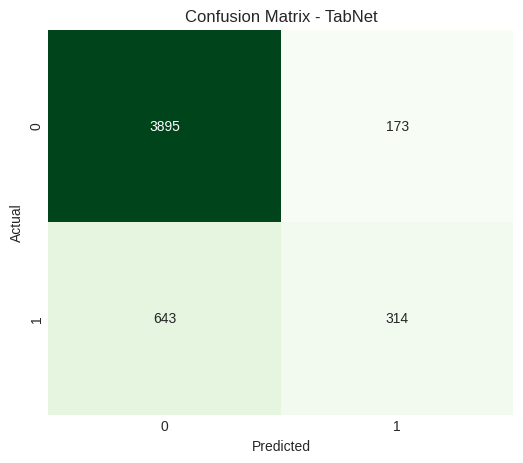

In [105]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch

# Prepare Data
df = df_test.copy()
df.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df.drop(columns=[target])
y = df[target]

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert to numpy arrays (TabNet requires this)
X_train_np = X_train.values
X_val_np = X_val.values
# y_train_np = y_train.values.reshape(-1, 1)
# y_val_np = y_val.values.reshape(-1, 1)
y_train_np = y_train.values
y_val_np = y_val.values

# Define TabNet model
tabnet_model = TabNetClassifier(
    n_d=16, n_a=16,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    verbose=10,
    seed=42
)

# Train
tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['auc'],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predict
y_pred = tabnet_model.predict(X_val_np)
y_proba = tabnet_model.predict_proba(X_val_np)[:, 1]

# Evaluation
f1 = f1_score(y_val, y_pred)
f2 = fbeta_score(y_val, y_pred, beta=2.0)
auc = roc_auc_score(y_val, y_proba)

print("\nTabNet Performance:")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - TabNet')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Not very promising , Catboost next

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.1 MB/s eta 0:00:00
0:	learn: 0.6079268	test: 0.5971208	best: 0.5971208 (0)	total: 88.2ms	remaining: 1m 28s
100:	learn: 0.6442770	test: 0.6260658	best: 0.6283743 (86)	total: 1.72s	remaining: 15.3s
200:	learn: 0.6636758	test: 0.6301149	best: 0.6319613 (152)	total: 3.11s	remaining: 12.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6319612591
bestIteration = 152

Shrink model to first 153 iterations.
F1 Score: 0.5225225225225225
Recall Score: 0.5454545454545454
ROC AUC Score: 0.7089367122552963
F2 Score: 0.5360443622920518


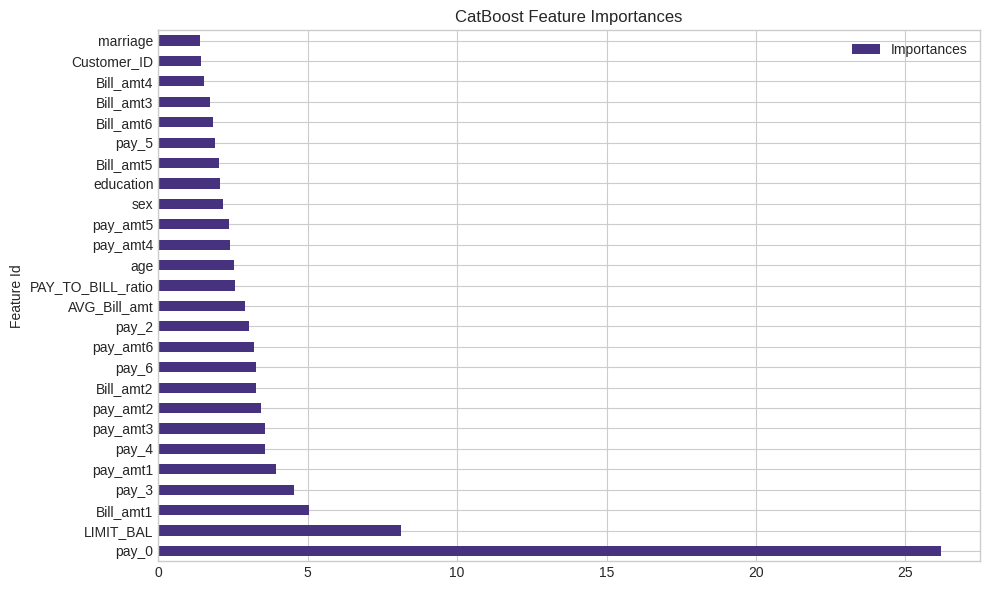

In [101]:
# Create a new copy of the cleaned test dataset
df6 = df_test.copy()

# Define target column
target_column = 'next_month_default'

# Separate features and target
X = df6.drop(columns=[target_column])
y = df6[target_column]

# Identify categorical features (CatBoost handles them automatically)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Install and import CatBoost
!pip install catboost --quiet

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, fbeta_score

# Initialize CatBoost classifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    random_seed=42,
    early_stopping_rounds=50,
    class_weights=[1, 3],  # You can adjust this ratio based on class imbalance
    verbose=100
)

# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))

# Feature importance plot
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance(prettified=True)
feature_importances.plot(kind='barh', x='Feature Id', y='Importances', figsize=(10, 6))
plt.title("CatBoost Feature Importances")
plt.tight_layout()
plt.show()


Seeing its good performance i am exploring it further.

# Catboost

0:	learn: 0.6795795	test: 0.6661744	best: 0.6661744 (0)	total: 154ms	remaining: 1m 16s
100:	learn: 0.7064933	test: 0.6838433	best: 0.6853250 (82)	total: 4.75s	remaining: 18.8s
200:	learn: 0.7272162	test: 0.6820699	best: 0.6853250 (82)	total: 8.46s	remaining: 12.6s
300:	learn: 0.7588961	test: 0.6823783	best: 0.6865567 (222)	total: 11.9s	remaining: 7.85s
400:	learn: 0.7874522	test: 0.6751553	best: 0.6865567 (222)	total: 15.6s	remaining: 3.86s
499:	learn: 0.8100318	test: 0.6750923	best: 0.6865567 (222)	total: 18.5s	remaining: 0us

bestTest = 0.6865566799
bestIteration = 222

Shrink model to first 223 iterations.

CatBoost Performance:
F1 Score: 0.5012
F2 Score: 0.5724
AUC-ROC: 0.7785

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      4068
           1       0.42      0.63      0.50       957

    accuracy                           0.76      5025
   macro avg       0.66      0.71      0.67      5025
weighted avg  

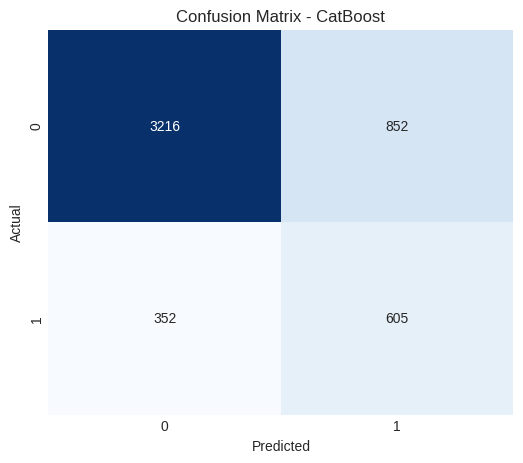

In [102]:
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score,
    classification_report, confusion_matrix
)
from catboost import CatBoostClassifier

df7 = df_test_engineered.copy()
df7.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df7.drop(columns=[target])
y = df7[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1]
        auc_roc = roc_auc_score(y, y_scores)
    else:
        auc_roc = None

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    if auc_roc:
        print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

cat_f2, cat_auc, _ = evaluate_model(cat_model, X_val, y_val, "CatBoost")


After some trial and error we reach an F2 score of 0.57 using catboost with original + engineered features

So the most promising till now is catboost (on original + engineered features), so i will proceed with doing SHAP on it.

0:	learn: 0.6795795	test: 0.6661744	best: 0.6661744 (0)	total: 60.5ms	remaining: 30.2s
100:	learn: 0.7064933	test: 0.6838433	best: 0.6853250 (82)	total: 3.05s	remaining: 12s
200:	learn: 0.7272162	test: 0.6820699	best: 0.6853250 (82)	total: 7.29s	remaining: 10.8s
300:	learn: 0.7588961	test: 0.6823783	best: 0.6865567 (222)	total: 10s	remaining: 6.62s
400:	learn: 0.7874522	test: 0.6751553	best: 0.6865567 (222)	total: 13s	remaining: 3.21s
499:	learn: 0.8100318	test: 0.6750923	best: 0.6865567 (222)	total: 15.1s	remaining: 0us

bestTest = 0.6865566799
bestIteration = 222

Shrink model to first 223 iterations.

CatBoost Performance:
F1 Score: 0.5012
F2 Score: 0.5724
AUC-ROC: 0.7785

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      4068
           1       0.42      0.63      0.50       957

    accuracy                           0.76      5025
   macro avg       0.66      0.71      0.67      5025
weighted avg       0

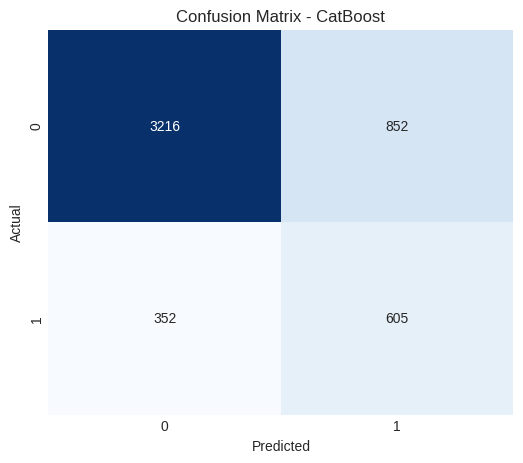

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score,
    classification_report, confusion_matrix
)
from catboost import CatBoostClassifier

df7 = df_test_engineered.copy()
df7.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df7.drop(columns=[target])
y = df7[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1]
        auc_roc = roc_auc_score(y, y_scores)
    else:
        auc_roc = None

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    if auc_roc:
        print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

cat_f2, cat_auc, _ = evaluate_model(cat_model, X_val, y_val, "CatBoost")



In [108]:
from catboost import CatBoostClassifier, Pool

# ---------- Data Setup ----------
df8 = df_test_engineered.copy()
df8.drop(columns=['Customer_ID'], inplace=True, errors='ignore')

target = 'next_month_default'
X = df8.drop(columns=[target])
y = df8[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------- Train Base CatBoost Model ----------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# ---------- SHAP Value Calculation ----------
train_pool = Pool(X_train, label=y_train)
shap_values = cat_model.get_feature_importance(train_pool, type="ShapValues")
shap_values = shap_values[:, :-1]  # Drop expected value column

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_train.columns).sort_values(ascending=False)

# ---------- Evaluate Models with Top-K SHAP Features ----------
results = []
for k in range(5, 21):
    top_k_features = shap_importance.head(k).index.tolist()
    X_train_k = X_train[top_k_features]
    X_val_k = X_val[top_k_features]

    model_k = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        eval_metric='F1',
        scale_pos_weight=scale_pos_weight,
        random_seed=42,
        verbose=0
    )
    model_k.fit(X_train_k, y_train, eval_set=(X_val_k, y_val), use_best_model=True)

    y_pred_k = model_k.predict(X_val_k)
    f2_k = fbeta_score(y_val, y_pred_k, beta=2.0)
    auc_k = roc_auc_score(y_val, model_k.predict_proba(X_val_k)[:, 1])
    results.append((k, f2_k, auc_k))

# ---------- Results ----------
shap_k_results = pd.DataFrame(results, columns=["Top_K", "F2_Score", "AUC_ROC"])
print(shap_k_results.sort_values(by="F2_Score", ascending=False).reset_index(drop=True))


0:	learn: 0.6795795	test: 0.6661744	best: 0.6661744 (0)	total: 17.5ms	remaining: 8.71s
100:	learn: 0.7064933	test: 0.6838433	best: 0.6853250 (82)	total: 3.71s	remaining: 14.7s
200:	learn: 0.7272162	test: 0.6820699	best: 0.6853250 (82)	total: 7.49s	remaining: 11.1s
300:	learn: 0.7588961	test: 0.6823783	best: 0.6865567 (222)	total: 10.6s	remaining: 7.01s
400:	learn: 0.7874522	test: 0.6751553	best: 0.6865567 (222)	total: 13.4s	remaining: 3.31s
499:	learn: 0.8100318	test: 0.6750923	best: 0.6865567 (222)	total: 15.4s	remaining: 0us

bestTest = 0.6865566799
bestIteration = 222

Shrink model to first 223 iterations.
    Top_K  F2_Score   AUC_ROC
0      19  0.575758  0.778572
1      15  0.574172  0.776786
2      14  0.571994  0.777754
3      18  0.571591  0.777722
4      12  0.571159  0.775195
5      16  0.571023  0.774694
6      20  0.570833  0.777155
7      17  0.570611  0.776935
8       8  0.570060  0.774017
9      13  0.569167  0.774753
10     11  0.568417  0.774741
11     10  0.567603  0.

In [109]:
top_19_features = shap_importance.head(19).index.tolist()
print(top_19_features)


['payment_delay_count', 'pay_0', 'LIMIT_BAL', 'credit_utilization', 'Bill_amt1', 'recent_delinquency', 'pay_amt1', 'pay_amt2', 'minimum_payment_count', 'delinquency_streak', 'payment_consistency', 'pay_amt4', 'sex', 'pay_ratio_3', 'pay_3', 'marriage', 'pay_amt6', 'pay_4', 'pay_ratio_volatility']


0:	learn: 0.6611520	test: 0.6547163	best: 0.6547163 (0)	total: 52.1ms	remaining: 26s
100:	learn: 0.7059949	test: 0.6835689	best: 0.6835689 (100)	total: 3.5s	remaining: 13.8s
200:	learn: 0.7201151	test: 0.6878520	best: 0.6884955 (162)	total: 6.11s	remaining: 9.09s
300:	learn: 0.7437815	test: 0.6790792	best: 0.6895236 (208)	total: 8.31s	remaining: 5.49s
400:	learn: 0.7681581	test: 0.6800423	best: 0.6895236 (208)	total: 10.4s	remaining: 2.57s
499:	learn: 0.7886192	test: 0.6749078	best: 0.6895236 (208)	total: 12.8s	remaining: 0us

bestTest = 0.6895236356
bestIteration = 208

Shrink model to first 209 iterations.

CatBoost (Top 19 SHAP Features) Performance:
F1 Score: 0.5048
F2 Score: 0.5758
AUC-ROC: 0.7786

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      4068
           1       0.42      0.64      0.50       957

    accuracy                           0.76      5025
   macro avg       0.66      0.71      0.67   

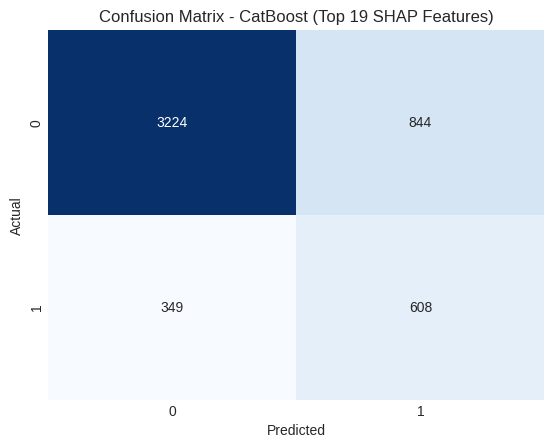

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score,
    classification_report, confusion_matrix
)
from catboost import CatBoostClassifier

# Select top 19 SHAP features
top_19_features = shap_importance.head(19).index.tolist()

# Create DataFrame with selected features and target
df9 = df_test_engineered.copy()
df9.drop(columns=['Customer_ID'], inplace=True, errors='ignore')
df9 = df9[top_19_features + ['next_month_default']]

X = df9.drop(columns=['next_month_default'])
y = df9['next_month_default']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)
    auc_roc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

cat_model1 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=100
)

cat_model1.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

cat_f2, cat_auc, _ = evaluate_model(cat_model1, X_val, y_val, "CatBoost (Top 19 SHAP Features)")


0:	learn: 0.9040958	test: 0.6879775	best: 0.6879775 (0)	total: 100ms	remaining: 49.9s
100:	learn: 0.9196047	test: 0.7004120	best: 0.7048307 (87)	total: 5.08s	remaining: 20.1s
200:	learn: 0.9254174	test: 0.7070597	best: 0.7070597 (199)	total: 10.9s	remaining: 16.2s
300:	learn: 0.9306442	test: 0.7053038	best: 0.7083719 (244)	total: 14.9s	remaining: 9.82s
400:	learn: 0.9352560	test: 0.7030449	best: 0.7083719 (244)	total: 18.5s	remaining: 4.56s
499:	learn: 0.9383263	test: 0.6971282	best: 0.7083719 (244)	total: 23.2s	remaining: 0us

bestTest = 0.7083719161
bestIteration = 244

Shrink model to first 245 iterations.

CatBoost + SMOTE (Top 19 SHAP Features) Performance:
F1 Score: 0.4222
F2 Score: 0.5923
AUC-ROC: 0.7584

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.52      0.67      4068
           1       0.29      0.81      0.42       957

    accuracy                           0.58      5025
   macro avg       0.60      0.67    

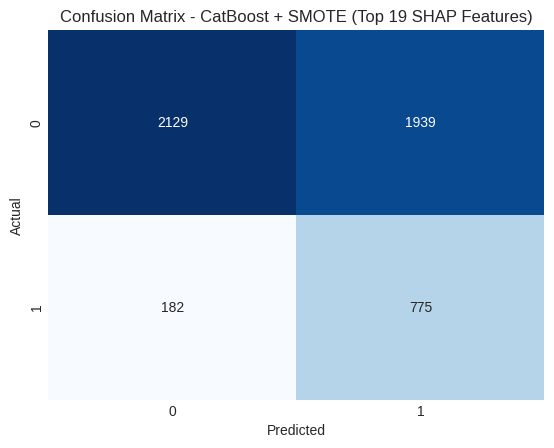

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

# Select top 19 SHAP features
top_19_features = shap_importance.head(19).index.tolist()

# Create df10 with selected features and target
df10 = df_test_engineered.copy()
df10.drop(columns=['Customer_ID'], inplace=True, errors='ignore')
df10 = df10[top_19_features + ['next_month_default']]

# Split features and target
X = df10.drop(columns=['next_month_default'])
y = df10['next_month_default']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define evaluation function
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)
    auc_roc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

# Compute scale_pos_weight from original (not oversampled) training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define CatBoost model
cat_model3 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=100
)

# Train on SMOTE data
cat_model3.fit(X_train_smote, y_train_smote, eval_set=(X_val, y_val), use_best_model=True)

# Evaluate
cat_f2, cat_auc, _ = evaluate_model(cat_model3, X_val, y_val, "CatBoost + SMOTE (Top 19 SHAP Features)")


So , for F2 score maximization cat_model3 that is, catboost with top19 features (of engineered + original) from SHAP and smote on training data seems to be best till now (except of course that stacked ensemble from H2O automl pipeline)

Now that i have got my best model till now , i will proceed to train it on full train data to be able to generate better results on predictions csv file.

# Hyperparameter tuning

I am using bayesian optimization since its better than grid search with k fold cross validation , random search and generally catboost cv too.

In [116]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.5 MB/s eta 0:00:00


[I 2025-06-17 02:20:48,692] A new study created in memory with name: no-name-ac0aedb6-d929-45de-905b-328240b8d4d0
[I 2025-06-17 02:21:24,686] Trial 0 finished with value: 0.8052750705170323 and parameters: {'iterations': 358, 'depth': 7, 'learning_rate': 0.27592038209473174, 'l2_leaf_reg': 3.16056311839731, 'bagging_temperature': 0.11046276953025325, 'border_count': 160}. Best is trial 0 with value: 0.8052750705170323.
[I 2025-06-17 02:22:14,286] Trial 1 finished with value: 0.8154806532976607 and parameters: {'iterations': 500, 'depth': 9, 'learning_rate': 0.10923912062161897, 'l2_leaf_reg': 5.497233530124758, 'bagging_temperature': 0.6879663336253913, 'border_count': 223}. Best is trial 1 with value: 0.8154806532976607.
[I 2025-06-17 02:23:13,937] Trial 2 finished with value: 0.8167133445879392 and parameters: {'iterations': 521, 'depth': 9, 'learning_rate': 0.22307882720784242, 'l2_leaf_reg': 6.326590297946739, 'bagging_temperature': 0.8385586239995756, 'border_count': 194}. Best is


Best hyperparameters found:
{'iterations': 210, 'depth': 10, 'learning_rate': 0.010440629121792614, 'l2_leaf_reg': 7.201853984560657, 'bagging_temperature': 0.2687621099938288, 'border_count': 55}
0:	learn: 0.9085539	test: 0.6858699	best: 0.6858699 (0)	total: 33.8ms	remaining: 7.06s
100:	learn: 0.9168708	test: 0.6987616	best: 0.6993667 (99)	total: 9.42s	remaining: 10.2s
200:	learn: 0.9218925	test: 0.7049578	best: 0.7056318 (194)	total: 14s	remaining: 626ms
209:	learn: 0.9221853	test: 0.7051957	best: 0.7056745 (208)	total: 14.3s	remaining: 0us

bestTest = 0.7056744684
bestIteration = 208

Shrink model to first 209 iterations.

CatBoost + SMOTE + Optuna Performance:
F1 Score: 0.3954
F2 Score: 0.5877
AUC-ROC: 0.7596

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.41      0.56      4068
           1       0.26      0.87      0.40       957

    accuracy                           0.49      5025
   macro avg       0.59      0.64 

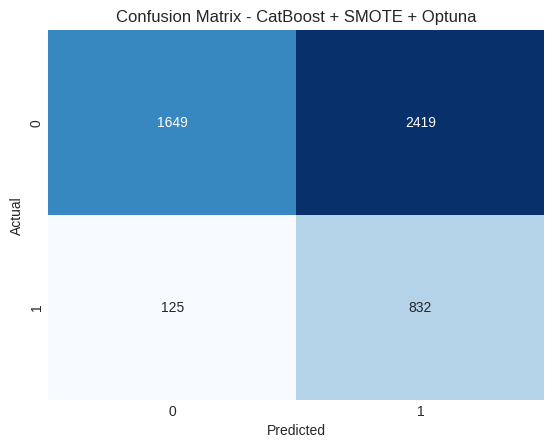

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")

# Select top 19 SHAP features
top_19_features = shap_importance.head(19).index.tolist()

# Create df10 with selected features and target
df10 = df_test_engineered.copy()
df10.drop(columns=['Customer_ID'], inplace=True, errors='ignore')
df10 = df10[top_19_features + ['next_month_default']]

# Split features and target
X = df10.drop(columns=['next_month_default'])
y = df10['next_month_default']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Compute scale_pos_weight from original (not oversampled) training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Evaluation function
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)
    auc_roc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

# Optuna objective function
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 600),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'F1',
        'verbose': 0,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    f2 = cross_val_score(
        model, X_train_smote, y_train_smote, cv=3,
        scoring=lambda est, X, y: fbeta_score(y, est.predict(X), beta=2.0)
    ).mean()

    return f2

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\nBest hyperparameters found:")
print(study.best_params)

# Train model using best hyperparameters
best_params = study.best_params
best_params.update({
    'eval_metric': 'F1',
    'scale_pos_weight': scale_pos_weight,
    'verbose': 100,
    'random_seed': 42
})

cat_model_optuna = CatBoostClassifier(**best_params)
cat_model_optuna.fit(X_train_smote, y_train_smote, eval_set=(X_val, y_val), use_best_model=True)

# Evaluate final model
cat_f2, cat_auc, _ = evaluate_model(cat_model_optuna, X_val, y_val, "CatBoost + SMOTE + Optuna")


So hyperparameter tuning increased recall from 0.81 to 0.87 but also slightly decreased precision and f2 score , so it may be better from a business perspective where catching defaulters is more important than sometimes flagging extra people.

Still since i want to optimize f2 score according to problem statement , i will couple optuna with stratified k fold (so that balanced searching happens) , and introduce more iterations(total 50) so that model gets more time to learn , also 50 is not very high so that i can avoid overfitting , for which i will also use built in catboost early stopping od_type and od_wait.

[I 2025-06-17 03:21:50,971] A new study created in memory with name: no-name-690242dd-e376-4225-bd0a-43c84fbfdeae
[I 2025-06-17 03:22:06,126] Trial 0 finished with value: 0.8812751594134519 and parameters: {'iterations': 932, 'depth': 9, 'learning_rate': 0.06503429367282686, 'l2_leaf_reg': 3.219815505464038, 'bagging_temperature': 0.9509469512854419, 'border_count': 77}. Best is trial 0 with value: 0.8812751594134519.
[I 2025-06-17 03:22:17,406] Trial 1 finished with value: 0.874367663992908 and parameters: {'iterations': 963, 'depth': 6, 'learning_rate': 0.046358729165776505, 'l2_leaf_reg': 8.455276511832768, 'bagging_temperature': 0.04185716195807776, 'border_count': 202}. Best is trial 0 with value: 0.8812751594134519.
[I 2025-06-17 03:22:26,059] Trial 2 finished with value: 0.8785218769713499 and parameters: {'iterations': 430, 'depth': 5, 'learning_rate': 0.1346276047513397, 'l2_leaf_reg': 5.225792118862591, 'bagging_temperature': 0.5434674518795345, 'border_count': 227}. Best is 


Best hyperparameters found:
{'iterations': 982, 'depth': 10, 'learning_rate': 0.07777010326915562, 'l2_leaf_reg': 6.461487234721526, 'bagging_temperature': 0.7052364561651246, 'border_count': 210}
0:	learn: 0.9072159	test: 0.6905769	best: 0.6905769 (0)	total: 52.5ms	remaining: 51.5s
100:	learn: 0.9398598	test: 0.7067664	best: 0.7113926 (83)	total: 5.19s	remaining: 45.3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7113926423
bestIteration = 83

Shrink model to first 84 iterations.

CatBoost + SMOTE + Optuna Performance:
F1 Score: 0.4292
F2 Score: 0.5961
AUC-ROC: 0.7579

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.54      0.68      4068
           1       0.29      0.80      0.43       957

    accuracy                           0.59      5025
   macro avg       0.61      0.67      0.56      5025
weighted avg       0.80      0.59      0.63      5025



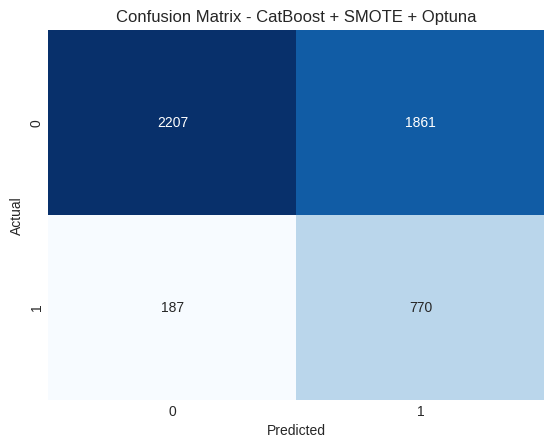

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
import optuna
import warnings
warnings.filterwarnings("ignore")

# Select top 19 SHAP features
top_19_features = shap_importance.head(19).index.tolist()

# Create df10 with selected features and target
df10 = df_test_engineered.copy()
df10.drop(columns=['Customer_ID'], inplace=True, errors='ignore')
df10 = df10[top_19_features + ['next_month_default']]

# Split features and target
X = df10.drop(columns=['next_month_default'])
y = df10['next_month_default']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Compute scale_pos_weight from original (not oversampled) training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Evaluation function
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    f2 = fbeta_score(y, y_pred, beta=2.0)
    auc_roc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"\n{name} Performance:")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return f2, auc_roc, model

# Optuna objective function
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 400, 1200),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'F1',
        'verbose': 0,
        'random_seed': 42,
        'od_type': 'Iter',               # Early stopping type
        'od_wait': 30                    # Early stopping patience
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train_smote, y_train_smote):
        X_tr, X_vl = X_train_smote.iloc[train_idx], X_train_smote.iloc[val_idx]
        y_tr, y_vl = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_vl, y_vl), use_best_model=True, early_stopping_rounds=30)
        y_pred = model.predict(X_vl)
        scores.append(fbeta_score(y_vl, y_pred, beta=2.0))

    return sum(scores) / len(scores)

# Run Optuna study with more trials
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1800)  # Increase trials, add timeout safeguard

print("\nBest hyperparameters found:")
print(study.best_params)

# Update best parameters with fixed args for final training
best_params = study.best_params
best_params.update({
    'eval_metric': 'F1',
    'scale_pos_weight': scale_pos_weight,
    'verbose': 100,
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 30
})

# Final model training with early stopping
cat_model_optuna = CatBoostClassifier(**best_params)
cat_model_optuna.fit(
    X_train_smote, y_train_smote,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=30
)

# Evaluate final model
cat_f2, cat_auc, _ = evaluate_model(cat_model_optuna, X_val, y_val, "CatBoost + SMOTE + Optuna")


# Final model

So finally from trying different models to coming on catboost, features obtained from feature engineering and shap analysis, hyperparameters obtained from hyperparameter tuning, and also using SMOT , i am putting together the final model. since i want the best predictions on real test set (not better than automl though), i will be now training on full train data instead of 80 20 split and i need not worry about over fitting because tuned hyperparameters can handle that. After that i will generate a prediction csv file from this model based on actual test data .

In [124]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Prepare full data
df_final = df_test_engineered.copy()
df_final.drop(columns=['Customer_ID'], inplace=True, errors='ignore')
df_final = df_final[top_19_features + ['next_month_default']]

X_full = df_final.drop(columns=['next_month_default'])
y_full = df_final['next_month_default']

# Apply SMOTE to full data (optional)
smote = SMOTE(random_state=42)
X_full_smote, y_full_smote = smote.fit_resample(X_full, y_full)

# Compute scale_pos_weight (optional for imbalance)
scale_pos_weight = (y_full == 0).sum() / (y_full == 1).sum()

# Final CatBoost model
final_model = CatBoostClassifier(
    iterations=84,
    depth=10,
    learning_rate=0.0778,
    l2_leaf_reg=6.46,
    bagging_temperature=0.705,
    border_count=210,
    scale_pos_weight=scale_pos_weight,
    eval_metric='F1',
    verbose=100,
    random_seed=42
)

# Train on SMOTE data
final_model.fit(X_full_smote, y_full_smote)


0:	learn: 0.9075374	total: 168ms	remaining: 13.9s
83:	learn: 0.9236726	total: 7.35s	remaining: 0us


In [128]:
df_test1 = pd.read_csv('/content/testset_creditcard.csv')
df_test_engineered = df_test1.copy()

In [129]:

# Define the payment columns used repeatedly
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

# 1. Credit Utilization Ratio
df_test_engineered['credit_utilization'] = df_test_engineered['Bill_amt1'] / df_test_engineered['LIMIT_BAL']
df_test_engineered['credit_utilization'] = df_test_engineered['credit_utilization'].clip(0, 5)

# 2. Payment consistency (variance in pay columns)
df_test_engineered['payment_consistency'] = df_test_engineered[pay_cols].var(axis=1)

# 3. Delinquency streak (consecutive months of delay from pay_0 onward)
def count_delinquency_streak(row):
    streak = 0
    for col in pay_cols:
        if row[col] > 0:
            streak += 1
        else:
            break
    return streak
df_test_engineered['delinquency_streak'] = df_test_engineered.apply(count_delinquency_streak, axis=1)

# 4. Payment-to-bill ratios
df_test_engineered['pay_ratio_1'] = df_test_engineered['pay_amt1'] / (df_test_engineered['Bill_amt1'] + 1)
df_test_engineered['pay_ratio_2'] = df_test_engineered['pay_amt2'] / (df_test_engineered['Bill_amt2'] + 1)
df_test_engineered['pay_ratio_3'] = df_test_engineered['pay_amt3'] / (df_test_engineered['Bill_amt3'] + 1)
df_test_engineered['pay_ratio_trend'] = df_test_engineered['pay_ratio_1'] - df_test_engineered['pay_ratio_3']

# 5. Payment delay count (how many months show delay)
df_test_engineered['payment_delay_count'] = (df_test_engineered[pay_cols] > 0).sum(axis=1)

# 6. Full payment count (-1 values in pay_cols)
df_test_engineered['full_payment_count'] = (df_test_engineered[pay_cols] == -1).sum(axis=1)

# 7. No consumption count (-2 values in pay_cols)
df_test_engineered['no_consumption_count'] = (df_test_engineered[pay_cols] == -2).sum(axis=1)

# 8. Minimum payment count (0 in pay_cols)
df_test_engineered['minimum_payment_count'] = (df_test_engineered[pay_cols] == 0).sum(axis=1)

# 9. Volatility in payment behavior
pay_ratio_cols = ['pay_ratio_1', 'pay_ratio_2', 'pay_ratio_3']
df_test_engineered['pay_ratio_volatility'] = df_test_engineered[pay_ratio_cols].std(axis=1)

# 10. Recent delinquency in last 2 months
df_test_engineered['recent_delinquency'] = ((df_test_engineered['pay_0'] > 0) | (df_test_engineered['pay_2'] > 0)).astype(int)


In [130]:
# Select same top 19 features used in training
top_19_features = [
    'payment_delay_count', 'pay_0', 'LIMIT_BAL', 'credit_utilization', 'Bill_amt1',
    'recent_delinquency', 'pay_amt1', 'pay_amt2', 'minimum_payment_count',
    'delinquency_streak', 'payment_consistency', 'pay_amt4', 'sex', 'pay_ratio_3',
    'pay_3', 'marriage', 'pay_amt6', 'pay_4', 'pay_ratio_volatility'
]

# Extract features for prediction
X_test_final = df_test_engineered[top_19_features]


In [131]:
y_test_pred = final_model.predict(X_test_final)


In [132]:
df_test_final_output = df_test1.copy()
df_test_final_output['next_month_default'] = y_test_pred


In [142]:
print(df_test_final_output.head())


   Customer_ID  marriage  sex  education  LIMIT_BAL  age  pay_0  pay_2  pay_3  \
0            1         1    1          2     220000   32      0      0      0   
1            2         2    0          1     350000   35     -1     -1     -1   
2            3         2    1          1     310000   39      0      0      0   
3            4         1    0          2      20000   47      0      0      0   
4            5         2    1          2     500000   30      0      0      0   

   pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  \
0      0  ...   15670.47   2000.03   3999.90   1419.80   1999.97   3000.21   
1      0  ...    2261.45  33891.01  16267.19   4026.80    234.10   1565.11   
2      0  ...  246524.45  11026.94  10499.83  14000.32  10000.12  10000.16   
3      2  ...   14749.97   1200.00   2799.83      0.14   1499.93      0.02   
4      0  ...   64841.30  25463.94  43095.31   7521.96   9065.17   8841.07   

   pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio

In [141]:
df_test_final_output.to_csv('predictions_final.csv', index=False)
